# In this Notebook

This notebook contains my initial experiments and wrangling. I proceed to the point where I realize my model is fundamentally flawed without the question of population. 

In this notebook I identify change in voting turnout from the previous year to be the variable I wish to model and I develop the Beta distribution framework for tackling the problem

## Data Loading

The following cell contains the freely accessible data I was able to wrangle. Unfortunately I only have two years to work with so we'll be dealing with significant bias, but the show must go on. 

Swing state spending 2020: https://www.democracyinaction.us/2020/states/advertisingoverview.html

Swing state spending 2016: https://www.nbcnews.com/politics/first-read/pro-clinton-battleground-ad-spending-outstrips-trump-team-2-1-n677911

In [2]:
headers = 'State	D-ad-spending	R-ad-spending	Turnout (D)	Prior-Turnout (D)'

data_2020 = '''Florida	220	121	50.08	49.38
Pennsylvania	177	91	50.59	49.62
North Carolina	68	87	49.32	48.1
Michigan	114	37	51.41	49.88
Arizona	82	58	50.16	48.11
Wisconsin	82	46	49.45	49.59
Georgia	19	38	50.12	47.34
Nevada	27	8	51.22	51.29
Minnesota	23	12	60.39	50.83
Ohio	17	12	45.92	45.73
Texas	23	9	47.17	45.29
Iowa	9	20	45.82	44.94
Nebraska	4.6	1.9	40.22	36.45
New Hampshire	4.4	0.3	53.75	50.2
Maine	2.1	2.4	54.67	51.6'''

data_2016 = '''Florida	77	38	49.38	50.44
Ohio	46	19	45.73	51.51
North Carolina	33	16	48.1	48.97
Pennsylvania	29	15	49.62	52.73
Nevada	25	9	51.29	53.41
Iowa	16	2.6	44.94	52.96
Colorado	11	6	52.68	52.75
New Hampshire	11	5.2	50.2	52.83
Virginia	6.6	5.1	52.83	51.97
Wisconsin	2.7	6.7	49.59	53.46
Michigan	2.6	1.6	49.88	54.8
Maine	0.4	0.7	51.6	57.86
New Mexico	0.1	0.2	54.65	55.3'''

In [3]:
# !pip install pandas matplotlib numpy scikit-learn seaborn

In [4]:
import pandas as pd
from io import StringIO

# Define column headers
columns = headers.split('\t')

# Load 2020 data
df_2020 = pd.read_csv(StringIO(data_2020), sep='\t', names=columns)

# Load 2015 data (this is the "2016" cycle, as you said 2015; adjust if needed)
df_2016 = pd.read_csv(StringIO(data_2016), sep='\t', names=columns)


In [5]:
df_2016.head()

,State,D-ad-spending,R-ad-spending,Turnout (D),Prior-Turnout (D)
0,Florida,77.0,38.0,49.38,50.44
1,Ohio,46.0,19.0,45.73,51.51
2,North Carolina,33.0,16.0,48.10,48.97
3,Pennsylvania,29.0,15.0,49.62,52.73
4,Nevada,25.0,9.0,51.29,53.41


In [6]:
df_2020.head()

,State,D-ad-spending,R-ad-spending,Turnout (D),Prior-Turnout (D)
0,Florida,220.0,121.0,50.08,49.38
1,Pennsylvania,177.0,91.0,50.59,49.62
2,North Carolina,68.0,87.0,49.32,48.10
3,Michigan,114.0,37.0,51.41,49.88
4,Arizona,82.0,58.0,50.16,48.11


## Plots

/tmp/ipykernel_27869/4079664124.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/tmp/ipykernel_27869/4079664124.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(


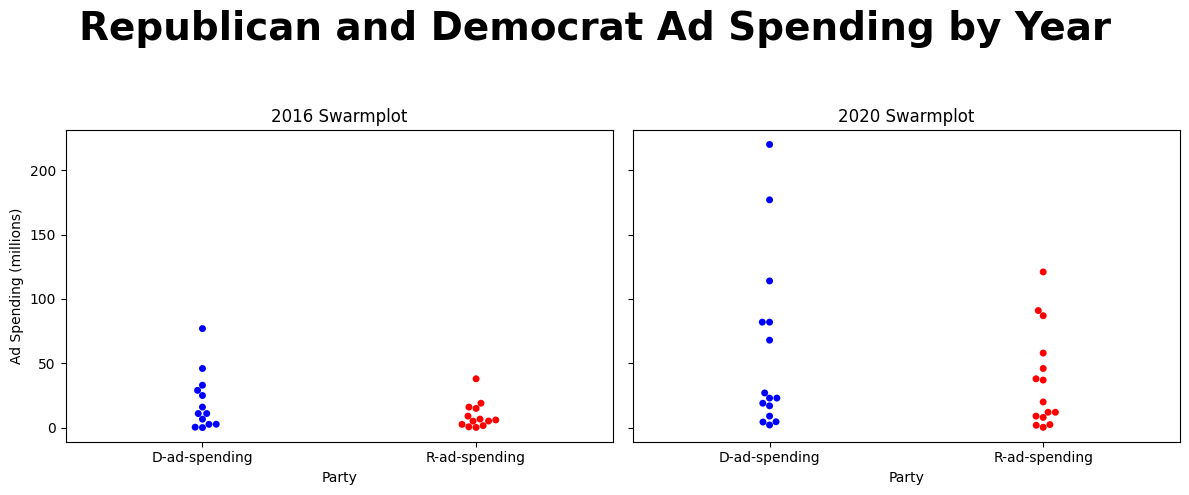

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data in long format for both years
df_2016_long = df_2016.melt(
    id_vars=['State'],
    value_vars=['D-ad-spending', 'R-ad-spending'],
    var_name='Party',
    value_name='Ad Spending'
)
df_2016_long['Year'] = 2016

df_2020_long = df_2020.melt(
    id_vars=['State'],
    value_vars=['D-ad-spending', 'R-ad-spending'],
    var_name='Party',
    value_name='Ad Spending'
)
df_2020_long['Year'] = 2020

# Concatenate into one dataframe
swarm_df = pd.concat([df_2016_long, df_2020_long], ignore_index=True)

# Plot swarmplots for each year
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.swarmplot(
    data=swarm_df[swarm_df['Year'] == 2016],
    x='Party',
    y='Ad Spending',
    ax=axes[0],
    palette={'D-ad-spending': 'blue', 'R-ad-spending': 'red'}
)
axes[0].set_title("2016 Swarmplot")
axes[0].set_xlabel("Party")
axes[0].set_ylabel("Ad Spending (millions)")

sns.swarmplot(
    data=swarm_df[swarm_df['Year'] == 2020],
    x='Party',
    y='Ad Spending',
    ax=axes[1],
    palette={'D-ad-spending': 'blue', 'R-ad-spending': 'red'}
)
axes[1].set_title("2020 Swarmplot")
axes[1].set_xlabel("Party")
axes[1].set_ylabel("")

plt.suptitle(
    "Republican and Democrat Ad Spending by Year",
    fontsize=28,  # Much bigger title
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


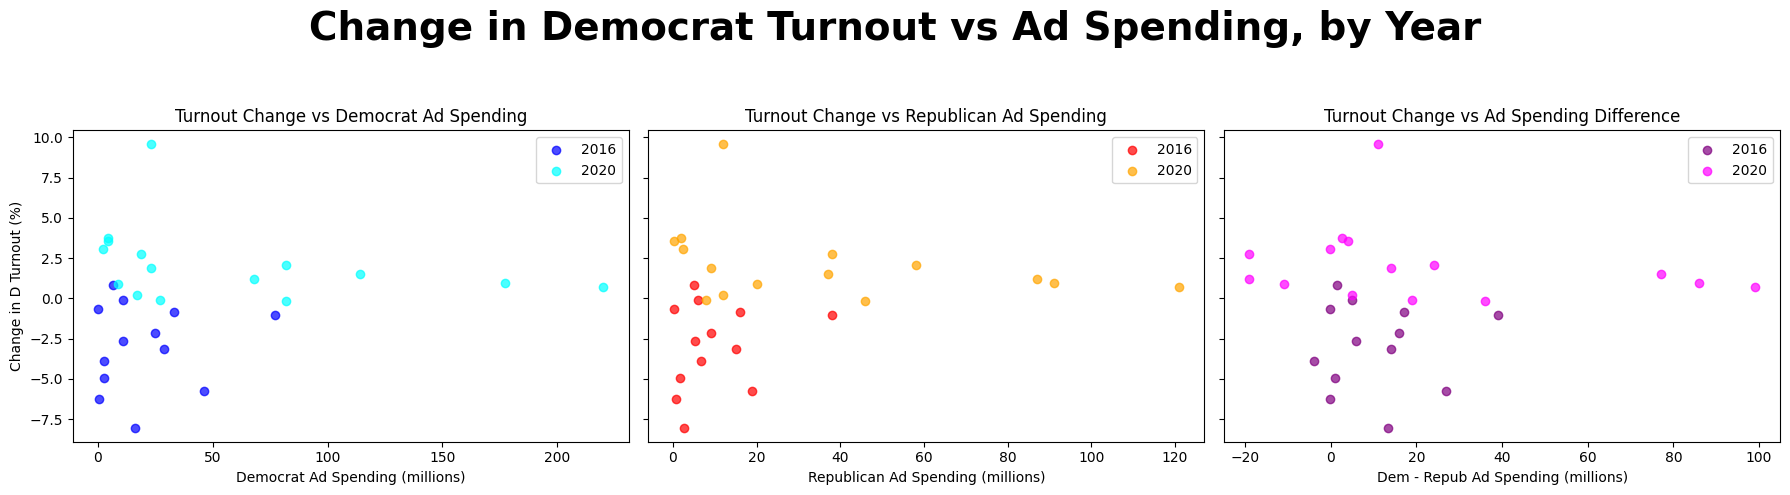

In [8]:
# Calculate difference in turnout for each year
df_2016['Turnout_diff'] = df_2016['Turnout (D)'] - df_2016['Prior-Turnout (D)']
df_2020['Turnout_diff'] = df_2020['Turnout (D)'] - df_2020['Prior-Turnout (D)']

# Plot settings
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1. Turnout_diff vs Democrat ad spending
axes[0].scatter(df_2016['D-ad-spending'], df_2016['Turnout_diff'], color='blue', label='2016', alpha=0.7)
axes[0].scatter(df_2020['D-ad-spending'], df_2020['Turnout_diff'], color='cyan', label='2020', alpha=0.7)
axes[0].set_xlabel('Democrat Ad Spending (millions)')
axes[0].set_ylabel('Change in D Turnout (%)')
axes[0].set_title('Turnout Change vs Democrat Ad Spending')
axes[0].legend()

# 2. Turnout_diff vs Republican ad spending
axes[1].scatter(df_2016['R-ad-spending'], df_2016['Turnout_diff'], color='red', label='2016', alpha=0.7)
axes[1].scatter(df_2020['R-ad-spending'], df_2020['Turnout_diff'], color='orange', label='2020', alpha=0.7)
axes[1].set_xlabel('Republican Ad Spending (millions)')
axes[1].set_title('Turnout Change vs Republican Ad Spending')
axes[1].legend()

# 3. Turnout_diff vs Dem-Repub ad spending difference
axes[2].scatter(
    df_2016['D-ad-spending'] - df_2016['R-ad-spending'],
    df_2016['Turnout_diff'], color='purple', label='2016', alpha=0.7
)
axes[2].scatter(
    df_2020['D-ad-spending'] - df_2020['R-ad-spending'],
    df_2020['Turnout_diff'], color='magenta', label='2020', alpha=0.7
)
axes[2].set_xlabel('Dem - Repub Ad Spending (millions)')
axes[2].set_title('Turnout Change vs Ad Spending Difference')
axes[2].legend()

plt.suptitle(
    "Change in Democrat Turnout vs Ad Spending, by Year",
    fontsize=28,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

This is discouraging. There isn't enough data for a noticeable trend to be found. The y-axis on all three plots is voter turnout for democrats. But as you can see, the Democrats almost always out-spend the Republicans but the few cases where Republicans actually out-spent Democrats occured in 2020 in which almost all of the swing states went Democrat. So there are other forces at work here

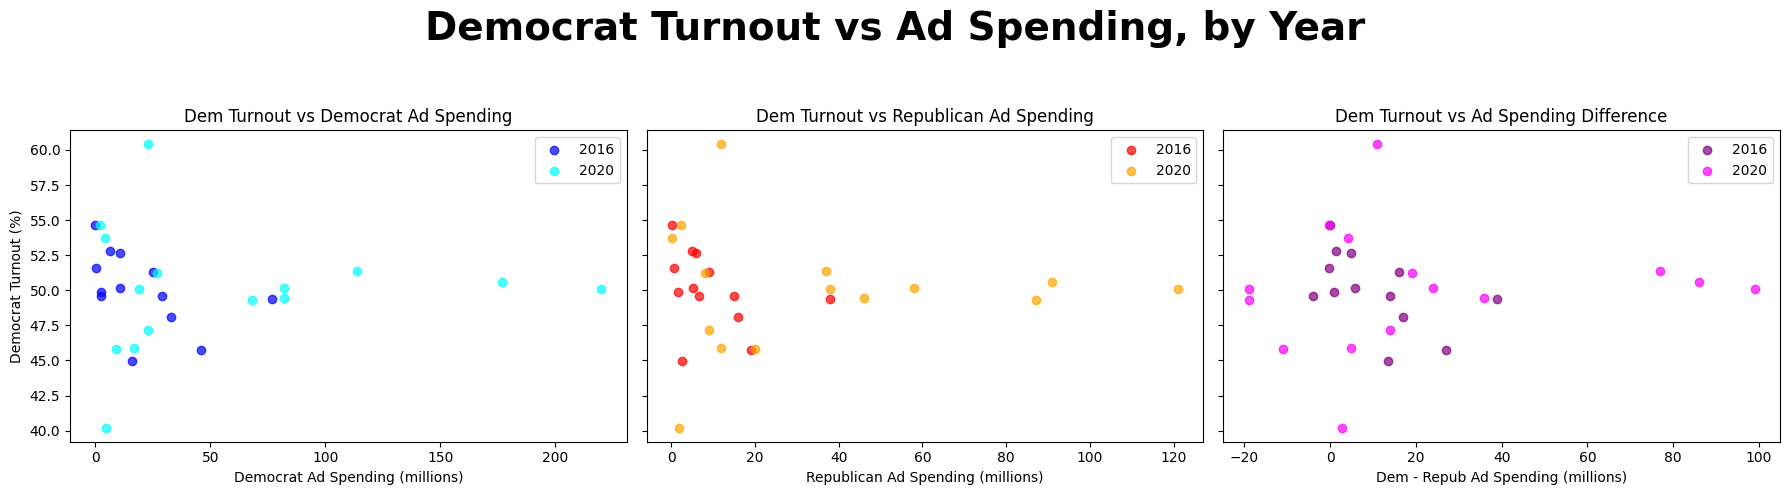

In [9]:
# Repeat the above plots, but using raw turnout instead of difference in turnout

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1. Turnout vs Democrat ad spending
axes[0].scatter(df_2016['D-ad-spending'], df_2016['Turnout (D)'], color='blue', label='2016', alpha=0.7)
axes[0].scatter(df_2020['D-ad-spending'], df_2020['Turnout (D)'], color='cyan', label='2020', alpha=0.7)
axes[0].set_xlabel('Democrat Ad Spending (millions)')
axes[0].set_ylabel('Democrat Turnout (%)')
axes[0].set_title('Dem Turnout vs Democrat Ad Spending')
axes[0].legend()

# 2. Turnout vs Republican ad spending
axes[1].scatter(df_2016['R-ad-spending'], df_2016['Turnout (D)'], color='red', label='2016', alpha=0.7)
axes[1].scatter(df_2020['R-ad-spending'], df_2020['Turnout (D)'], color='orange', label='2020', alpha=0.7)
axes[1].set_xlabel('Republican Ad Spending (millions)')
axes[1].set_title('Dem Turnout vs Republican Ad Spending')
axes[1].legend()

# 3. Turnout vs Dem-Repub ad spending difference
axes[2].scatter(
    df_2016['D-ad-spending'] - df_2016['R-ad-spending'],
    df_2016['Turnout (D)'], color='purple', label='2016', alpha=0.7
)
axes[2].scatter(
    df_2020['D-ad-spending'] - df_2020['R-ad-spending'],
    df_2020['Turnout (D)'], color='magenta', label='2020', alpha=0.7
)
axes[2].set_xlabel('Dem - Repub Ad Spending (millions)')
axes[2].set_title('Dem Turnout vs Ad Spending Difference')
axes[2].legend()

plt.suptitle(
    "Democrat Turnout vs Ad Spending, by Year",
    fontsize=28,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


This is equally unhelpful

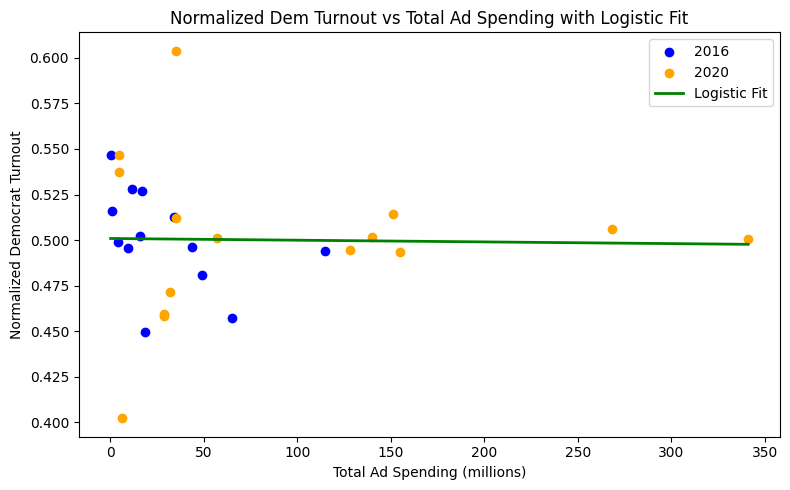

In [10]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Normalize turnout by dividing by 100
df_2016['Turnout_norm'] = df_2016['Turnout (D)'] / 100
df_2020['Turnout_norm'] = df_2020['Turnout (D)'] / 100

# Define logistic function
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Choose an independent variable, e.g., total ad spending (D + R)
df_2016['Total-ads'] = df_2016['D-ad-spending'] + df_2016['R-ad-spending']
df_2020['Total-ads'] = df_2020['D-ad-spending'] + df_2020['R-ad-spending']

# Concatenate for a general fit (or fit separately if needed)
X = np.concatenate([df_2016['Total-ads'], df_2020['Total-ads']])
y = np.concatenate([df_2016['Turnout_norm'], df_2020['Turnout_norm']])

# Initial guesses for parameters: L (max), k (growth rate), x0 (midpoint)
p0 = [1.0, 0.01, np.median(X)]

# Fit curve
params, cov = curve_fit(logistic, X, y, p0, maxfev=10000)

# Generate points for plotting the fitted curve
x_fit = np.linspace(X.min(), X.max(), 200)
y_fit = logistic(x_fit, *params)

# Plot normalized turnout and logistic fit
plt.figure(figsize=(8, 5))
plt.scatter(df_2016['Total-ads'], df_2016['Turnout_norm'], color='blue', label='2016')
plt.scatter(df_2020['Total-ads'], df_2020['Turnout_norm'], color='orange', label='2020')
plt.plot(x_fit, y_fit, color='green', label='Logistic Fit', linewidth=2)
plt.xlabel('Total Ad Spending (millions)')
plt.ylabel('Normalized Democrat Turnout')
plt.title('Normalized Dem Turnout vs Total Ad Spending with Logistic Fit')
plt.legend()
plt.tight_layout()
plt.show()


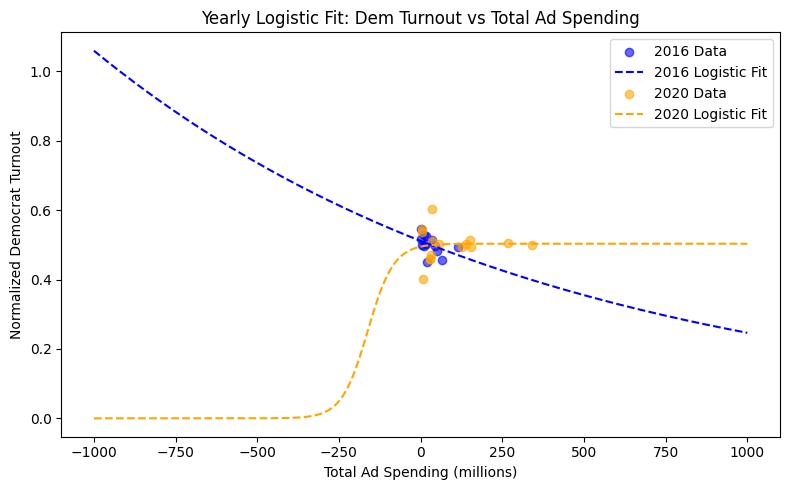

In [11]:
# Logistic fit for each year separately

def fit_and_plot_logistic(df, year, color):
    # Ensure no missing values
    data = df.dropna(subset=['Total-ads', 'Turnout_norm'])
    X = data['Total-ads'].values
    y = data['Turnout_norm'].values

    # Initial parameter guesses
    p0 = [1.0, 0.01, np.median(X)]
    params, _ = curve_fit(logistic, X, y, p0, maxfev=10000)
    # Interpolate x from -1000 to 1000 instead of data range
    x_fit = np.linspace(-1000, 1000, 400)
    y_fit = logistic(x_fit, *params)
    plt.scatter(X, y, color=color, alpha=0.6, label=f'{year} Data')
    plt.plot(x_fit, y_fit, color=color, linestyle="--", label=f'{year} Logistic Fit')
    return params

plt.figure(figsize=(8, 5))
params_2016 = fit_and_plot_logistic(df_2016, 2016, 'blue')
params_2020 = fit_and_plot_logistic(df_2020, 2020, 'orange')
plt.xlabel('Total Ad Spending (millions)')
plt.ylabel('Normalized Democrat Turnout')
plt.title('Yearly Logistic Fit: Dem Turnout vs Total Ad Spending')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
data_2024 = '''Pennsylvania    159     105     49.08   50.01
Michigan        151     52      49.29   50.6
Georgia         137     87      48.85   49.5
Arizona         91      61      47.22   49.4
Wisconsin       128     128     49.49   49.6
Nevada          21      7       48.37   50.1
North Carolina  109     109     47.74   48.6'''

import pandas as pd
from io import StringIO

cols = ['State', 'D-ad-spending', 'R-ad-spending', 'Turnout (D)', 'Prior-Turnout (D)']
df_2024 = pd.read_csv(
    StringIO(data_2024),
    sep=r'\s{2,}',
    names=cols,
    engine='python'
)

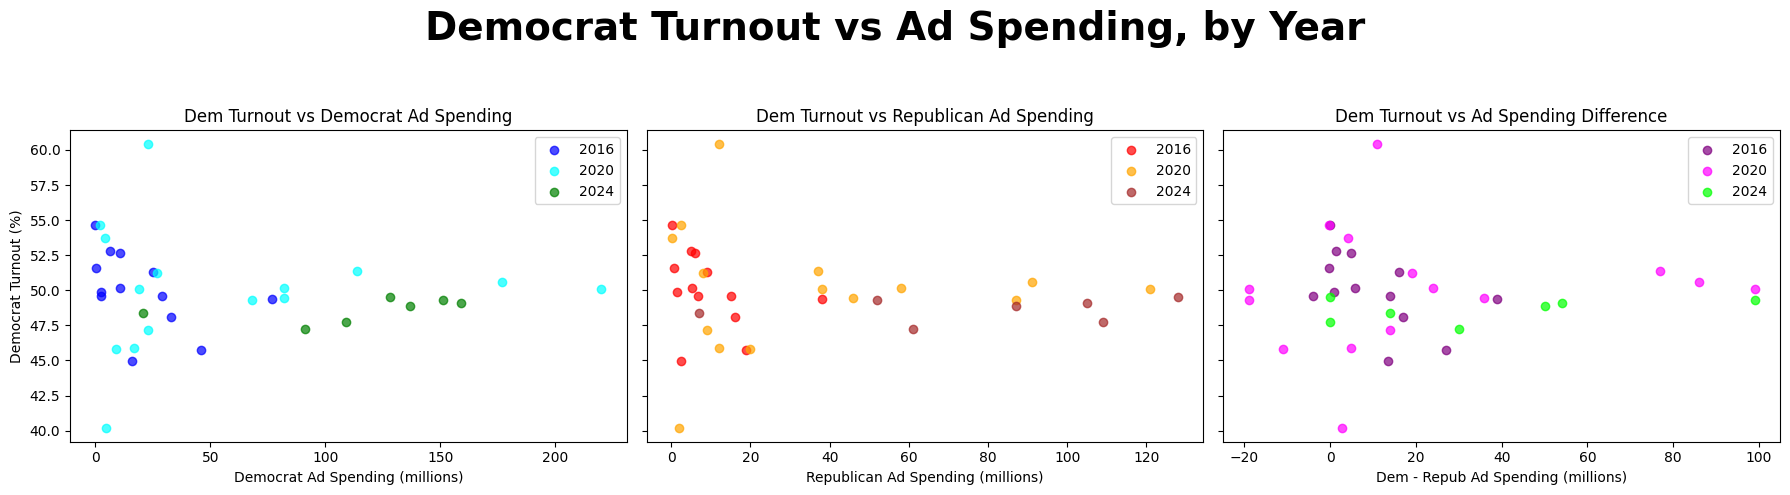

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1. Turnout vs Democrat ad spending
axes[0].scatter(df_2016['D-ad-spending'], df_2016['Turnout (D)'], color='blue', label='2016', alpha=0.7)
axes[0].scatter(df_2020['D-ad-spending'], df_2020['Turnout (D)'], color='cyan', label='2020', alpha=0.7)
axes[0].scatter(df_2024['D-ad-spending'], df_2024['Turnout (D)'], color='green', label='2024', alpha=0.7)
axes[0].set_xlabel('Democrat Ad Spending (millions)')
axes[0].set_ylabel('Democrat Turnout (%)')
axes[0].set_title('Dem Turnout vs Democrat Ad Spending')
axes[0].legend()

# 2. Turnout vs Republican ad spending
axes[1].scatter(df_2016['R-ad-spending'], df_2016['Turnout (D)'], color='red', label='2016', alpha=0.7)
axes[1].scatter(df_2020['R-ad-spending'], df_2020['Turnout (D)'], color='orange', label='2020', alpha=0.7)
axes[1].scatter(df_2024['R-ad-spending'], df_2024['Turnout (D)'], color='brown', label='2024', alpha=0.7)
axes[1].set_xlabel('Republican Ad Spending (millions)')
axes[1].set_title('Dem Turnout vs Republican Ad Spending')
axes[1].legend()

# 3. Turnout vs Dem-Repub ad spending difference
axes[2].scatter(
    df_2016['D-ad-spending'] - df_2016['R-ad-spending'],
    df_2016['Turnout (D)'], color='purple', label='2016', alpha=0.7
)
axes[2].scatter(
    df_2020['D-ad-spending'] - df_2020['R-ad-spending'],
    df_2020['Turnout (D)'], color='magenta', label='2020', alpha=0.7
)
axes[2].scatter(
    df_2024['D-ad-spending'] - df_2024['R-ad-spending'],
    df_2024['Turnout (D)'], color='lime', label='2024', alpha=0.7
)
axes[2].set_xlabel('Dem - Repub Ad Spending (millions)')
axes[2].set_title('Dem Turnout vs Ad Spending Difference')
axes[2].legend()

plt.suptitle(
    "Democrat Turnout vs Ad Spending, by Year",
    fontsize=28,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


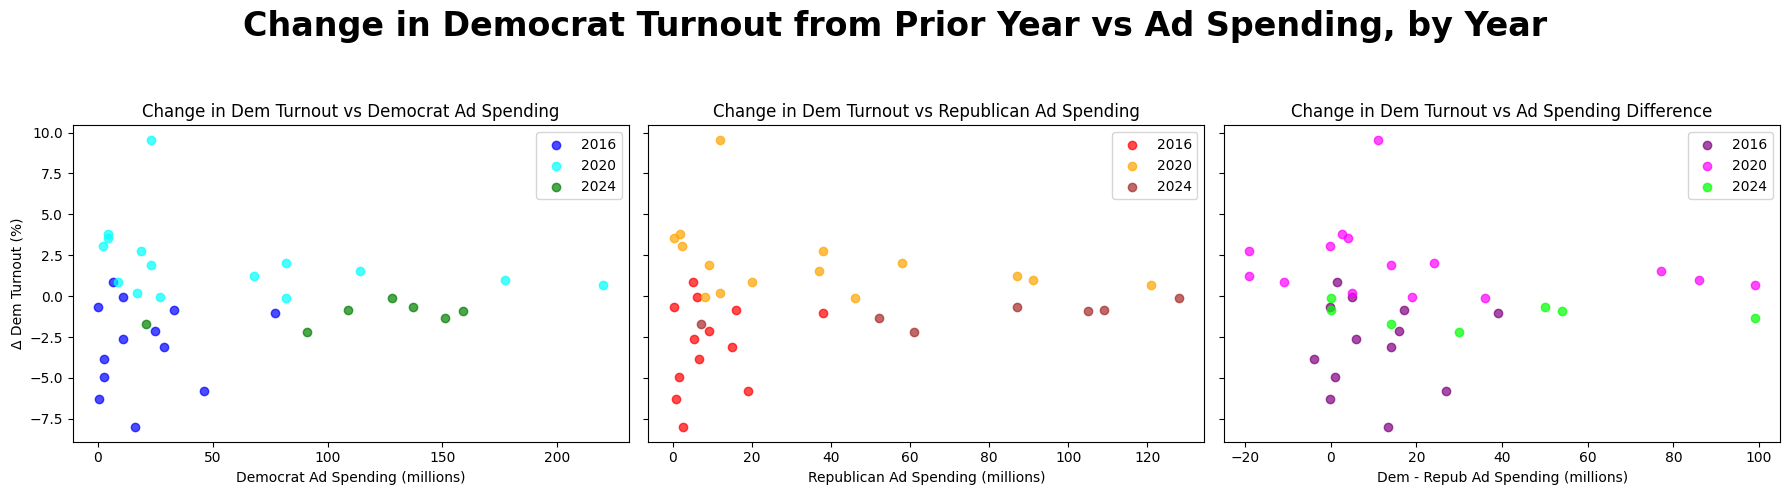

In [14]:
# Duplicate the prior plot but use the *relative* turnout from the prior year (i.e., Turnout (D) - Prior-Turnout (D))

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1. Relative Turnout vs Democrat ad spending
axes[0].scatter(df_2016['D-ad-spending'], df_2016['Turnout (D)'] - df_2016['Prior-Turnout (D)'], color='blue', label='2016', alpha=0.7)
axes[0].scatter(df_2020['D-ad-spending'], df_2020['Turnout (D)'] - df_2020['Prior-Turnout (D)'], color='cyan', label='2020', alpha=0.7)
axes[0].scatter(df_2024['D-ad-spending'], df_2024['Turnout (D)'] - df_2024['Prior-Turnout (D)'], color='green', label='2024', alpha=0.7)
axes[0].set_xlabel('Democrat Ad Spending (millions)')
axes[0].set_ylabel('Δ Dem Turnout (%)')
axes[0].set_title('Change in Dem Turnout vs Democrat Ad Spending')
axes[0].legend()

# 2. Relative Turnout vs Republican ad spending
axes[1].scatter(df_2016['R-ad-spending'], df_2016['Turnout (D)'] - df_2016['Prior-Turnout (D)'], color='red', label='2016', alpha=0.7)
axes[1].scatter(df_2020['R-ad-spending'], df_2020['Turnout (D)'] - df_2020['Prior-Turnout (D)'], color='orange', label='2020', alpha=0.7)
axes[1].scatter(df_2024['R-ad-spending'], df_2024['Turnout (D)'] - df_2024['Prior-Turnout (D)'], color='brown', label='2024', alpha=0.7)
axes[1].set_xlabel('Republican Ad Spending (millions)')
axes[1].set_title('Change in Dem Turnout vs Republican Ad Spending')
axes[1].legend()

# 3. Relative Turnout vs Dem-Repub ad spending difference
axes[2].scatter(
    df_2016['D-ad-spending'] - df_2016['R-ad-spending'],
    df_2016['Turnout (D)'] - df_2016['Prior-Turnout (D)'], color='purple', label='2016', alpha=0.7
)
axes[2].scatter(
    df_2020['D-ad-spending'] - df_2020['R-ad-spending'],
    df_2020['Turnout (D)'] - df_2020['Prior-Turnout (D)'], color='magenta', label='2020', alpha=0.7
)
axes[2].scatter(
    df_2024['D-ad-spending'] - df_2024['R-ad-spending'],
    df_2024['Turnout (D)'] - df_2024['Prior-Turnout (D)'], color='lime', label='2024', alpha=0.7
)
axes[2].set_xlabel('Dem - Repub Ad Spending (millions)')
axes[2].set_title('Change in Dem Turnout vs Ad Spending Difference')
axes[2].legend()

plt.suptitle(
    "Change in Democrat Turnout from Prior Year vs Ad Spending, by Year",
    fontsize=24,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


This 2012 data isn't accurate. It was based on the assumption that Obama spent 2/3 more than Romney but this is the best I can get

In [15]:

data_2012 = '''Florida          111     56      50.44   51.4
Ohio             97      48      51.51   52.3
Virginia         82      41      51.97   53.2
Colorado         46      23      52.75   50.9
North Carolina   37      28      48.97   51.1'''

cols = ['State', 'D-ad-spending', 'R-ad-spending', 'Turnout (D)', 'Prior-Turnout (D)']
df_2012 = pd.read_csv(
    StringIO(data_2012),
    sep=r'\s{2,}',
    names=cols,
    engine='python'
)

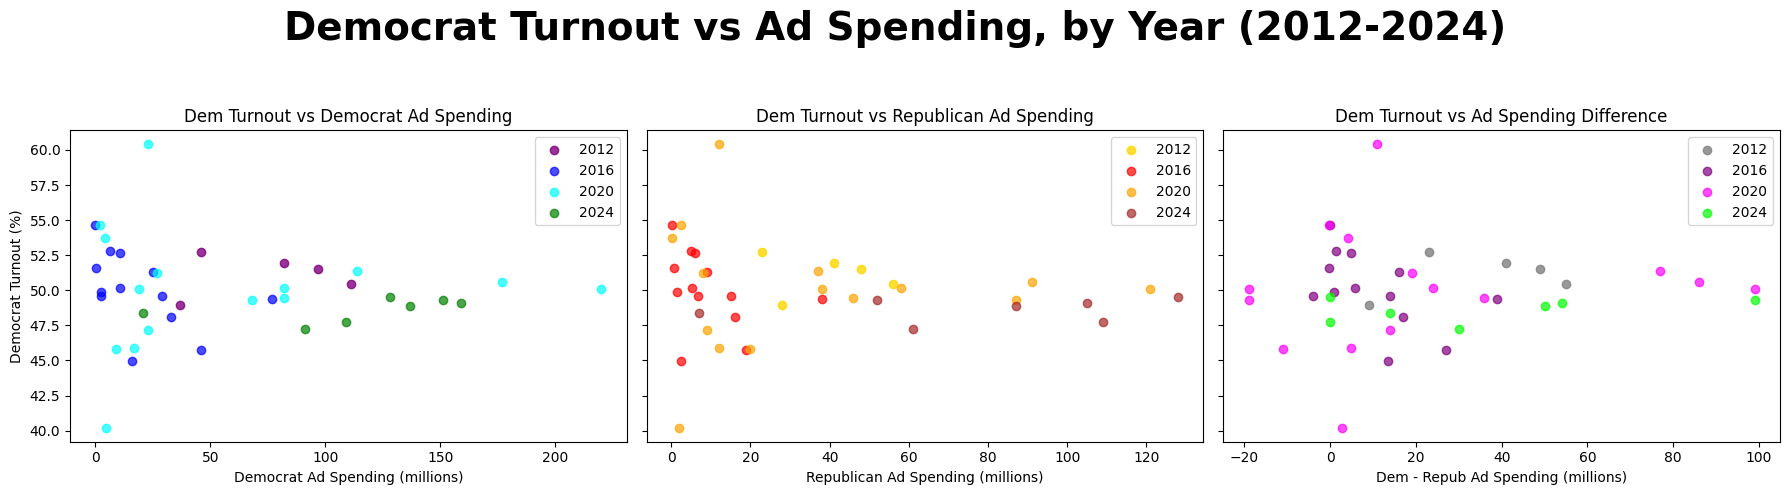

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1. Turnout vs Democrat ad spending
axes[0].scatter(df_2012['D-ad-spending'], df_2012['Turnout (D)'], color='purple', label='2012', alpha=0.8, linewidths=1)
axes[0].scatter(df_2016['D-ad-spending'], df_2016['Turnout (D)'], color='blue', label='2016', alpha=0.7)
axes[0].scatter(df_2020['D-ad-spending'], df_2020['Turnout (D)'], color='cyan', label='2020', alpha=0.7)
axes[0].scatter(df_2024['D-ad-spending'], df_2024['Turnout (D)'], color='green', label='2024', alpha=0.7)
axes[0].set_xlabel('Democrat Ad Spending (millions)')
axes[0].set_ylabel('Democrat Turnout (%)')
axes[0].set_title('Dem Turnout vs Democrat Ad Spending')
axes[0].legend()

# 2. Turnout vs Republican ad spending
axes[1].scatter(df_2012['R-ad-spending'], df_2012['Turnout (D)'], color='gold', label='2012', alpha=0.8, linewidths=1)
axes[1].scatter(df_2016['R-ad-spending'], df_2016['Turnout (D)'], color='red', label='2016', alpha=0.7)
axes[1].scatter(df_2020['R-ad-spending'], df_2020['Turnout (D)'], color='orange', label='2020', alpha=0.7)
axes[1].scatter(df_2024['R-ad-spending'], df_2024['Turnout (D)'], color='brown', label='2024', alpha=0.7)
axes[1].set_xlabel('Republican Ad Spending (millions)')
axes[1].set_title('Dem Turnout vs Republican Ad Spending')
axes[1].legend()

# 3. Turnout vs Dem-Repub ad spending difference
axes[2].scatter(
    df_2012['D-ad-spending'] - df_2012['R-ad-spending'],
    df_2012['Turnout (D)'], color='gray', label='2012', alpha=0.8, linewidths=1
)
axes[2].scatter(
    df_2016['D-ad-spending'] - df_2016['R-ad-spending'],
    df_2016['Turnout (D)'], color='purple', label='2016', alpha=0.7
)
axes[2].scatter(
    df_2020['D-ad-spending'] - df_2020['R-ad-spending'],
    df_2020['Turnout (D)'], color='magenta', label='2020', alpha=0.7
)
axes[2].scatter(
    df_2024['D-ad-spending'] - df_2024['R-ad-spending'],
    df_2024['Turnout (D)'], color='lime', label='2024', alpha=0.7
)
axes[2].set_xlabel('Dem - Repub Ad Spending (millions)')
axes[2].set_title('Dem Turnout vs Ad Spending Difference')
axes[2].legend()

plt.suptitle(
    "Democrat Turnout vs Ad Spending, by Year (2012-2024)",
    fontsize=28,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


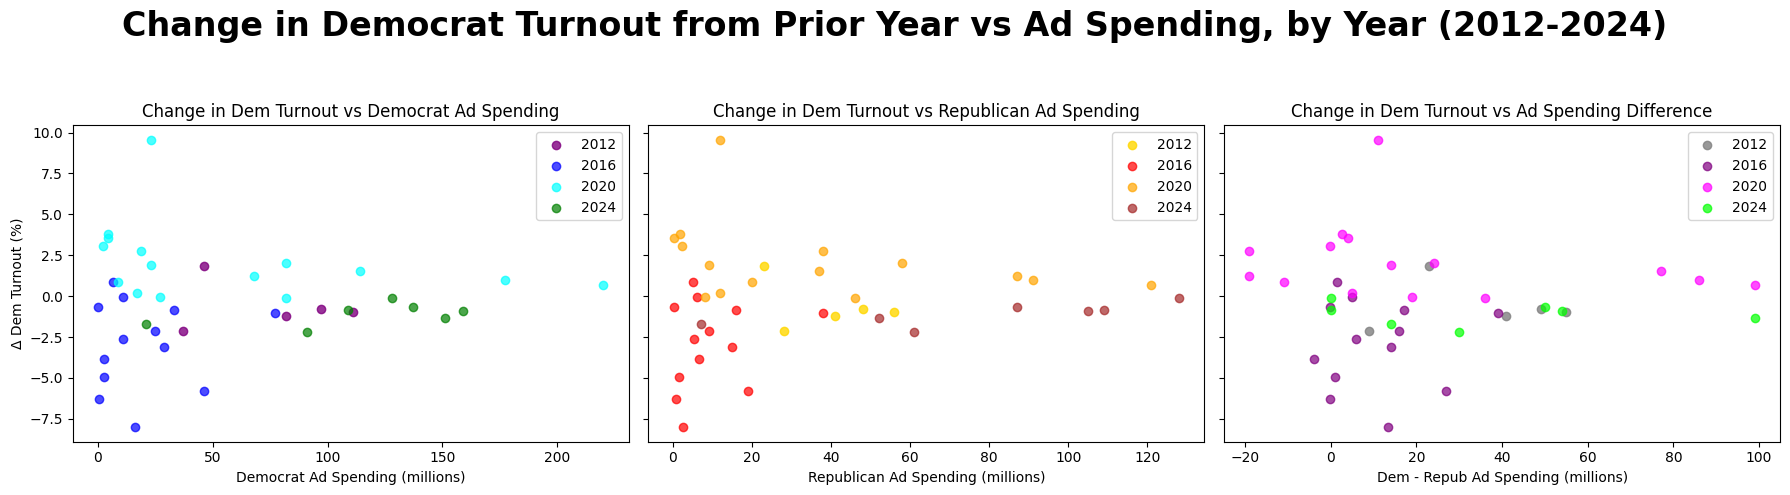

In [17]:
# Duplicate the prior plot but use the *relative* turnout from the prior year (i.e., Turnout (D) - Prior-Turnout (D)), for all four years (2012, 2016, 2020, 2024)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1. Relative Turnout vs Democrat ad spending
axes[0].scatter(df_2012['D-ad-spending'], df_2012['Turnout (D)'] - df_2012['Prior-Turnout (D)'], color='purple', label='2012', alpha=0.8, linewidths=1)
axes[0].scatter(df_2016['D-ad-spending'], df_2016['Turnout (D)'] - df_2016['Prior-Turnout (D)'], color='blue', label='2016', alpha=0.7)
axes[0].scatter(df_2020['D-ad-spending'], df_2020['Turnout (D)'] - df_2020['Prior-Turnout (D)'], color='cyan', label='2020', alpha=0.7)
axes[0].scatter(df_2024['D-ad-spending'], df_2024['Turnout (D)'] - df_2024['Prior-Turnout (D)'], color='green', label='2024', alpha=0.7)
axes[0].set_xlabel('Democrat Ad Spending (millions)')
axes[0].set_ylabel('Δ Dem Turnout (%)')
axes[0].set_title('Change in Dem Turnout vs Democrat Ad Spending')
axes[0].legend()

# 2. Relative Turnout vs Republican ad spending
axes[1].scatter(df_2012['R-ad-spending'], df_2012['Turnout (D)'] - df_2012['Prior-Turnout (D)'], color='gold', label='2012', alpha=0.8, linewidths=1)
axes[1].scatter(df_2016['R-ad-spending'], df_2016['Turnout (D)'] - df_2016['Prior-Turnout (D)'], color='red', label='2016', alpha=0.7)
axes[1].scatter(df_2020['R-ad-spending'], df_2020['Turnout (D)'] - df_2020['Prior-Turnout (D)'], color='orange', label='2020', alpha=0.7)
axes[1].scatter(df_2024['R-ad-spending'], df_2024['Turnout (D)'] - df_2024['Prior-Turnout (D)'], color='brown', label='2024', alpha=0.7)
axes[1].set_xlabel('Republican Ad Spending (millions)')
axes[1].set_title('Change in Dem Turnout vs Republican Ad Spending')
axes[1].legend()

# 3. Relative Turnout vs Dem-Repub ad spending difference
axes[2].scatter(
    df_2012['D-ad-spending'] - df_2012['R-ad-spending'],
    df_2012['Turnout (D)'] - df_2012['Prior-Turnout (D)'], color='gray', label='2012', alpha=0.8, linewidths=1
)
axes[2].scatter(
    df_2016['D-ad-spending'] - df_2016['R-ad-spending'],
    df_2016['Turnout (D)'] - df_2016['Prior-Turnout (D)'], color='purple', label='2016', alpha=0.7
)
axes[2].scatter(
    df_2020['D-ad-spending'] - df_2020['R-ad-spending'],
    df_2020['Turnout (D)'] - df_2020['Prior-Turnout (D)'], color='magenta', label='2020', alpha=0.7
)
axes[2].scatter(
    df_2024['D-ad-spending'] - df_2024['R-ad-spending'],
    df_2024['Turnout (D)'] - df_2024['Prior-Turnout (D)'], color='lime', label='2024', alpha=0.7
)
axes[2].set_xlabel('Dem - Repub Ad Spending (millions)')
axes[2].set_title('Change in Dem Turnout vs Ad Spending Difference')
axes[2].legend()

plt.suptitle(
    "Change in Democrat Turnout from Prior Year vs Ad Spending, by Year (2012-2024)",
    fontsize=24,
    fontweight='bold'
)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


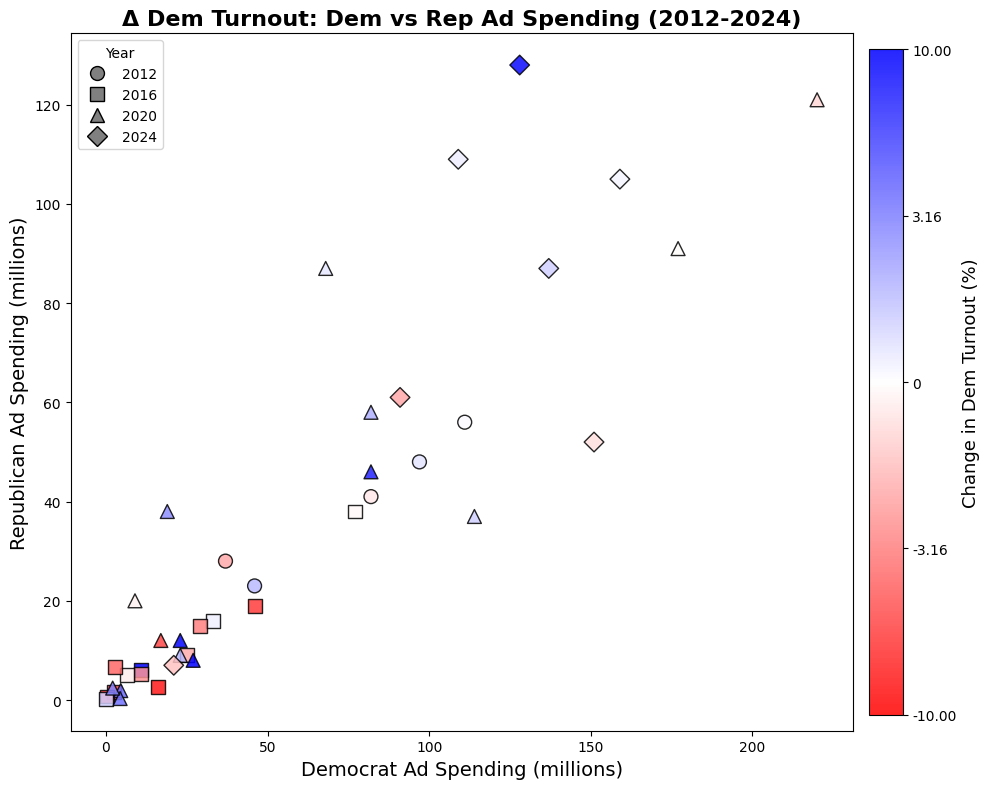

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

import pandas as pd
dfs = [df_2012, df_2016, df_2020, df_2024]
combined_df = pd.concat(dfs, keys=['2012', '2016', '2020', '2024'], names=['Year', 'Index']).reset_index()

# Calculate change in Dem turnout
combined_df['TurnoutChange'] = combined_df['Turnout (D)'] - combined_df['Prior-Turnout (D)']

# For log color scale: map signed values to log scale, preserving sign
def signed_log(values, min_abs=1e-2):
    # Avoid log(0): ensure minimum magnitude but preserve sign
    return np.sign(values) * np.log10(np.maximum(np.abs(values), min_abs))

combined_df['TurnoutChange_log'] = signed_log(combined_df['TurnoutChange'])

fig, ax = plt.subplots(figsize=(10,8))

# Set color normalization and colormap, centered at 0
vlim = 1  # log10(10) = 1 so vlim=1 covers -10 to 10 in original/linear space
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-vlim, vmax=vlim)
cmap = mcolors.LinearSegmentedColormap.from_list("blue_red", ["red", "white", "blue"])

# Assign a marker per year and plot year-by-year
year_marker_color = {
    '2012': ('o', 'gold'),
    '2016': ('s', 'purple'),
    '2020': ('^', 'magenta'),
    '2024': ('D', 'lime'),
}
for year in ['2012', '2016', '2020', '2024']:
    marker, color = year_marker_color[year]
    year_df = combined_df[combined_df['Year'] == year]
    sc = ax.scatter(
        year_df['D-ad-spending'],
        year_df['R-ad-spending'],
        c=year_df['TurnoutChange_log'],
        cmap=cmap,
        norm=norm,
        s=100,
        edgecolors='k',
        alpha=0.85,
        marker=marker,
        label=year
    )

ax.set_xlabel('Democrat Ad Spending (millions)', fontsize=14)
ax.set_ylabel('Republican Ad Spending (millions)', fontsize=14)
ax.set_title('Δ Dem Turnout: Dem vs Rep Ad Spending (2012-2024)', fontsize=16, fontweight='bold')

# Add colorbar with custom tick labels restoring to original scale
cbar = plt.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
log_ticks = np.array([-1, -0.5, 0, 0.5, 1])  # -10, -3.16, 0, 3.16, 10

cbar.set_ticks(log_ticks)
tick_labels = []
for t in log_ticks:
    if t == 0:
        tick_labels.append("0")
    elif t < 0:
        tick_labels.append(f"{-10**abs(t):.2f}")
    else:
        tick_labels.append(f"{10**abs(t):.2f}")
cbar.set_ticklabels(tick_labels)
cbar.set_label('Change in Dem Turnout (%)', fontsize=13)

# Add year legend handles correctly
handles = []
for year in ['2012','2016','2020','2024']:
    marker, color = year_marker_color[year]
    handles.append(
        plt.Line2D([], [], marker=marker, color='gray', markerfacecolor='gray', markeredgecolor='k', markersize=10, linestyle='None', label=year)
    )

ax.legend(handles=handles, title='Year', loc='upper left')

plt.tight_layout()
plt.show()


## Reformatting

In [19]:
df_2024.head()

,State,D-ad-spending,R-ad-spending,Turnout (D),Prior-Turnout (D)
0,Pennsylvania,159,105,49.08,50.01
1,Michigan,151,52,49.29,50.60
2,Georgia,137,87,48.85,49.50
3,Arizona,91,61,47.22,49.40
4,Wisconsin,128,128,49.49,49.60


In [20]:
df_2020.head()

,State,D-ad-spending,R-ad-spending,Turnout (D),Prior-Turnout (D),Turnout_diff,Turnout_norm,Total-ads
0,Florida,220.0,121.0,50.08,49.38,0.70,0.5008,341.0
1,Pennsylvania,177.0,91.0,50.59,49.62,0.97,0.5059,268.0
2,North Carolina,68.0,87.0,49.32,48.10,1.22,0.4932,155.0
3,Michigan,114.0,37.0,51.41,49.88,1.53,0.5141,151.0
4,Arizona,82.0,58.0,50.16,48.11,2.05,0.5016,140.0


In [21]:
df_2016.head()

,State,D-ad-spending,R-ad-spending,Turnout (D),Prior-Turnout (D),Turnout_diff,Turnout_norm,Total-ads
0,Florida,77.0,38.0,49.38,50.44,-1.06,0.4938,115.0
1,Ohio,46.0,19.0,45.73,51.51,-5.78,0.4573,65.0
2,North Carolina,33.0,16.0,48.10,48.97,-0.87,0.4810,49.0
3,Pennsylvania,29.0,15.0,49.62,52.73,-3.11,0.4962,44.0
4,Nevada,25.0,9.0,51.29,53.41,-2.12,0.5129,34.0


In [22]:
df_2012.head()

,State,D-ad-spending,R-ad-spending,Turnout (D),Prior-Turnout (D)
0,Florida,111,56,50.44,51.4
1,Ohio,97,48,51.51,52.3
2,Virginia,82,41,51.97,53.2
3,Colorado,46,23,52.75,50.9
4,North Carolina,37,28,48.97,51.1


In [23]:
# Remove specified columns from 2020 and 2016 dataframes
cols_to_drop = ['Turnout_diff', 'Turnout_norm', 'Total-ads']

df_2020_clean = df_2020.drop(columns=cols_to_drop, errors='ignore')
df_2016_clean = df_2016.drop(columns=cols_to_drop, errors='ignore')

# Combine 2012, 2016, 2020, and 2024 dataframes
combined_df = pd.concat([df_2012, df_2016_clean, df_2020_clean, df_2024], ignore_index=True)

# Display the combined dataframe's head for verification
print(combined_df.head())

            State  D-ad-spending  R-ad-spending  Turnout (D)  \
0         Florida          111.0           56.0        50.44   
1            Ohio           97.0           48.0        51.51   
2        Virginia           82.0           41.0        51.97   
3        Colorado           46.0           23.0        52.75   
4  North Carolina           37.0           28.0        48.97   

   Prior-Turnout (D)  
0               51.4  
1               52.3  
2               53.2  
3               50.9  
4               51.1  


## Fitting a Beta model

Here's what I've determined from the data analysis above. First off, it will be extremely difficult to model how the difference in ad spending affects turnout since neither party is stupid. They both realize that what matters for our electoral college are the swing states so they invest the majority of their resources there. That being said, the data isn't worthless, but I need to think about this problem better. 

When less ad money is spent by either party, the results are unpredictable. When more money is spent by both parties the results tend towards the middle. And since I will proceed with the prior that more ad money will always help, I will attempt to model the competitive nature of advertising using a Beta distribution. 

Below you can see the Beta distribution's PDF plotted for various values of our parameters $a$ and $b$. We will determine some functions $g(D)$ and $h(R)$ where $D$ and $R$ are the amount of advertising effort made by the Democrats and Republicans respectively that yield reasonable Beta distributions with $a=g(D)$ and $b=h(R)$ to predict the change in Democrat voters in a state. As such this is pretty much just a Bayesian Statistics problem.

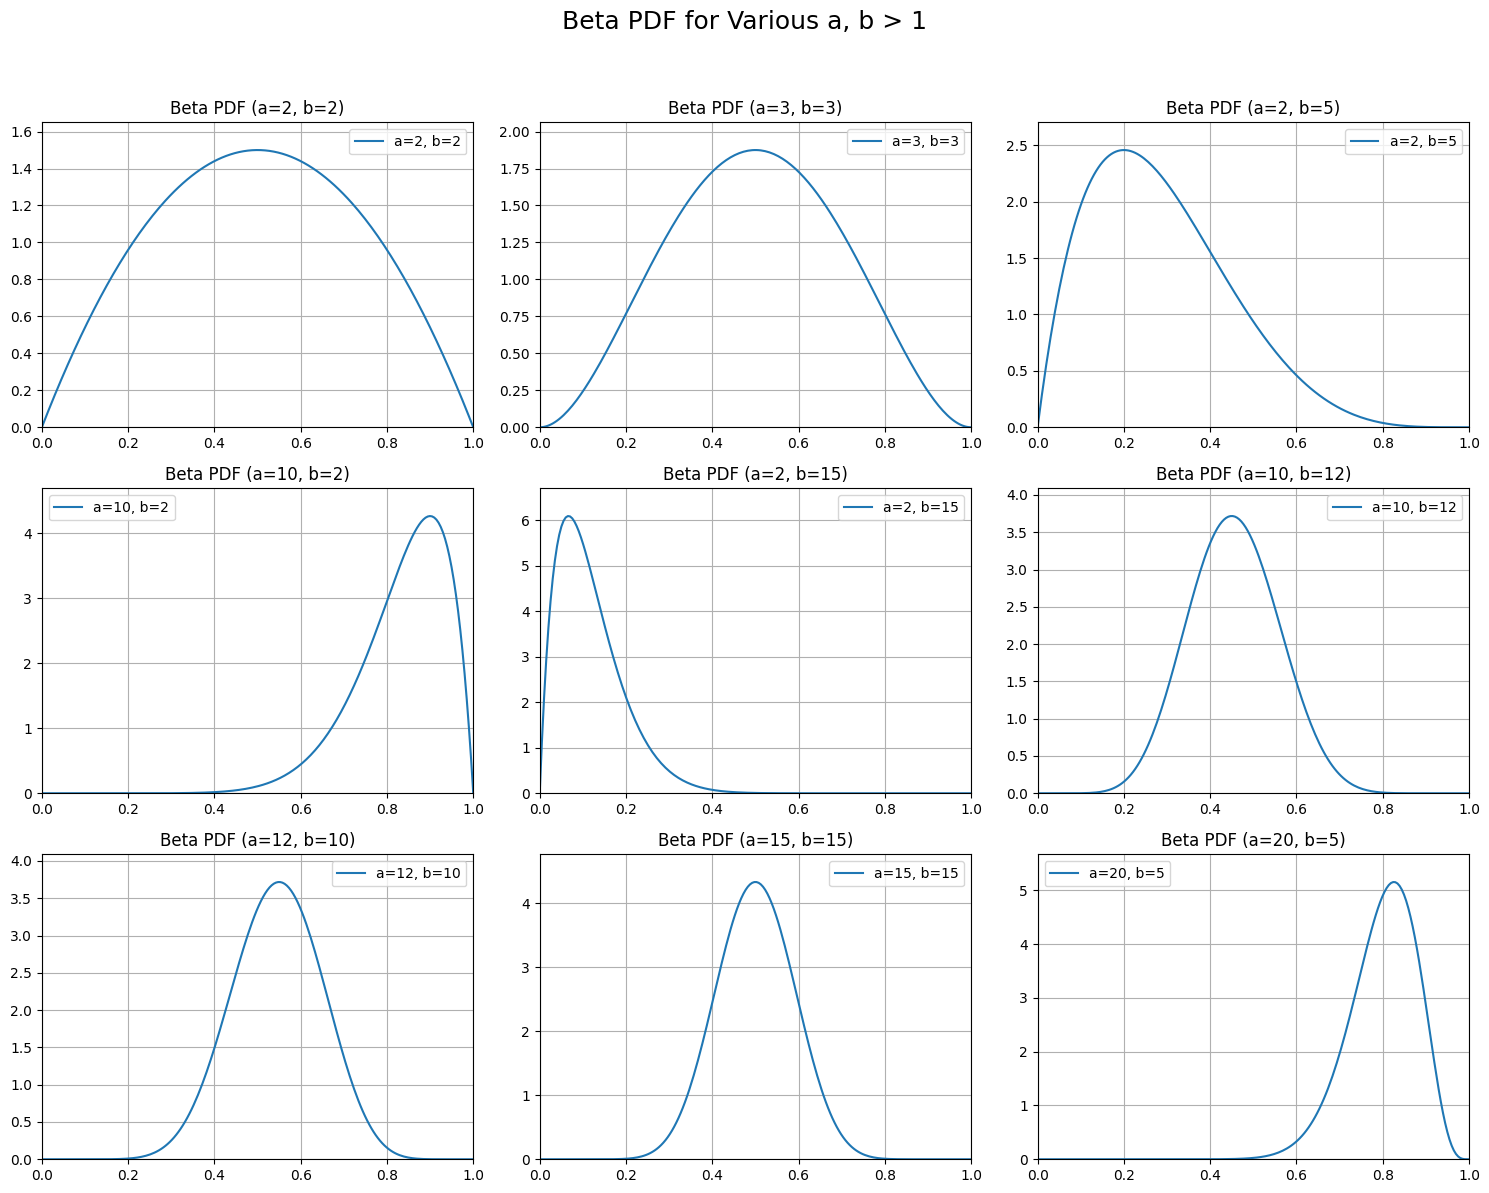

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Define range for x
x = np.linspace(0, 1, 200)

# Parameters for a and b > 1
params = [
    # A few low parameter cases
    (2, 2), (3, 3), (2, 5),
    # Majority high parameter: at least one of a or b > 10
    (10, 2), (2, 15), (10, 12),
    (12, 10), (15, 15), (20, 5)
]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Beta PDF for Various a, b > 1', fontsize=18, y=0.99)  # Move suptitle up

for idx, (a, b) in enumerate(params):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    y = beta.pdf(x, a, b)
    ax.plot(x, y, label=f'a={a}, b={b}')
    ax.set_title(f'Beta PDF (a={a}, b={b})', fontsize=12)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, np.max(y) * 1.1)
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


To start we're going to try and determine a good estimate for the $g(0)$ and $h(0)$. To do this we're going to take historic voting data in presidential elections and fit a Beta distribution to that data. This should give a ballpark estimate for the distribution that un-advertised states take. Oh but this brings up a problem... The Republicans typically win many more states than the Democrats but they're much smaller. I don't know if this is a good way to proceed but we'll look at what happens. 

This dataset was sourced here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ

In [25]:
df = pd.read_csv('countypres_2000-2024.csv')

state_votes = df[df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0)

state_votes.reset_index(inplace=True)
print(state_votes)

party  year          state  DEMOCRAT  REPUBLICAN
0      2000        ALABAMA    695602      944409
1      2000         ALASKA     79004      167398
2      2000        ARIZONA    685341      781652
3      2000       ARKANSAS    422768      472940
4      2000     CALIFORNIA   5861203     4567429
..      ...            ...       ...         ...
352    2024       VIRGINIA   2335395     2075085
353    2024     WASHINGTON   2245849     1530923
354    2024  WEST VIRGINIA    214309      533556
355    2024      WISCONSIN   1668229     1697626
356    2024        WYOMING     69527      192633

[357 rows x 4 columns]


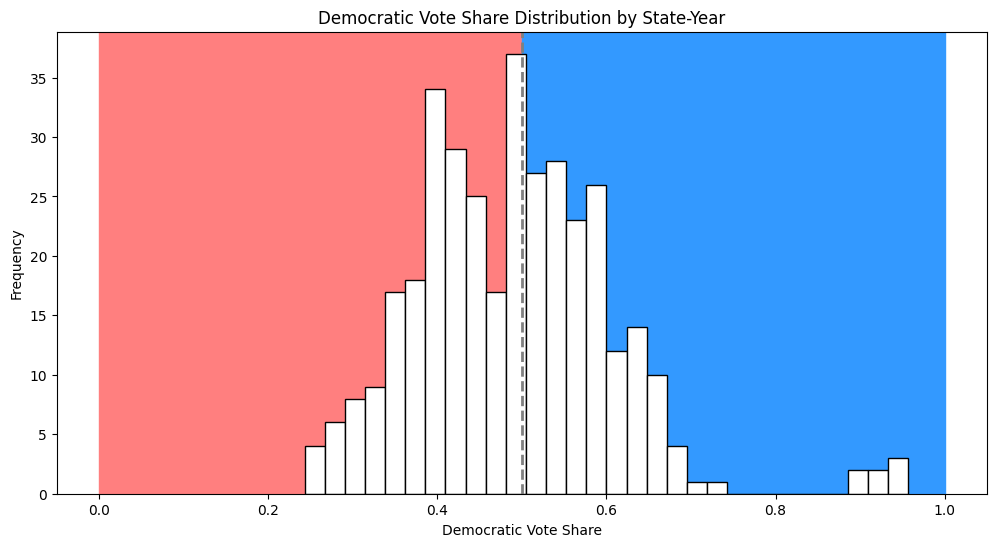

In [26]:
import matplotlib.pyplot as plt

state_votes['dem_share'] = state_votes['DEMOCRAT'] / (state_votes['DEMOCRAT'] + state_votes['REPUBLICAN'])

all_data = state_votes['dem_share']
bins = np.histogram_bin_edges(all_data, bins=30)

plt.figure(figsize=(12, 6))

# Add colored backgrounds for left and right of 0.5
plt.axvspan(0, 0.5, color='#ff7f7f', zorder=0)    # more saturated red (for R side)
plt.axvspan(0.5, 1, color='#3399ff', zorder=0)    # more saturated blue (for D side)

# Use white bars with black edges for a more appealing look
plt.hist(all_data, bins=bins, color='white', edgecolor='black', alpha=1.0, label='All States', zorder=2)
plt.xlabel('Democratic Vote Share')
plt.ylabel('Frequency')
plt.title('Democratic Vote Share Distribution by State-Year')
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.show()

What are those outliers on the right?

In [27]:
# Find the top-10 state-years with the highest democratic vote share
top7 = state_votes.sort_values('dem_share', ascending=False).head(7)
display(top7[['year', 'state', 'dem_share']])


party,year,state,dem_share
212,2016,DISTRICT OF COLUMBIA,0.956952
263,2020,DISTRICT OF COLUMBIA,0.944670
110,2008,DISTRICT OF COLUMBIA,0.934008
314,2024,DISTRICT OF COLUMBIA,0.933147
161,2012,DISTRICT OF COLUMBIA,0.925876
59,2004,DISTRICT OF COLUMBIA,0.905203
8,2000,DISTRICT OF COLUMBIA,0.904877


Okay the outliers are Washington DC. That's to be expected. We proceed

Method-of-moments estimates:
a_0 = 8.398, b_0 = 8.760
Maximum likelihood estimates:
a_0 (MLE) = 7.311, b_0 (MLE) = 7.507


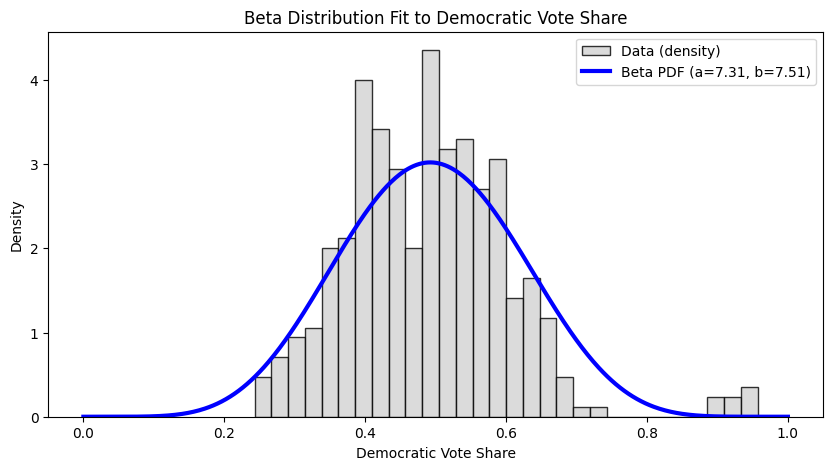

In [28]:
from scipy.stats import beta
from scipy.optimize import minimize_scalar
import numpy as np

# We'll use all_data, which is the state's dem_share
data = all_data.dropna().values
eps = 1e-7  # Avoid values at boundaries

# Clamp values into (0,1)
data = np.clip(data, eps, 1 - eps)
mean_x = np.mean(data)
var_x = np.var(data, ddof=1)
# Method of moments estimates for Beta distribution
common = mean_x * (1 - mean_x) / var_x - 1
a0 = mean_x * common
b0 = (1 - mean_x) * common

print("Method-of-moments estimates:")
print(f"a_0 = {a0:.3f}, b_0 = {b0:.3f}")

# Optionally, maximize the likelihood for better fit
from scipy.optimize import minimize

def neg_log_likelihood(params):
    a, b = params
    # Keep positive
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(beta.logpdf(data, a, b))

res = minimize(neg_log_likelihood, [a0, b0], bounds=[(1e-4, None), (1e-4, None)])
a_mle, b_mle = res.x

print("Maximum likelihood estimates:")
print(f"a_0 (MLE) = {a_mle:.3f}, b_0 (MLE) = {b_mle:.3f}")

# Plot the fitted beta PDF
x = np.linspace(0, 1, 500)
pdf = beta.pdf(x, a_mle, b_mle)

plt.figure(figsize=(10, 5))
plt.hist(data, bins=30, density=True, color="lightgray", edgecolor="black", alpha=0.8, label="Data (density)")
plt.plot(x, pdf, 'b-', lw=3, label=f"Beta PDF (a={a_mle:.2f}, b={b_mle:.2f})")
plt.xlabel('Democratic Vote Share')
plt.ylabel('Density')
plt.title('Beta Distribution Fit to Democratic Vote Share')
plt.legend()
plt.show()


Wait, we don't actually need this data... we're looking for the change in Democratic vote share by year...

/tmp/ipykernel_27869/2000438028.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


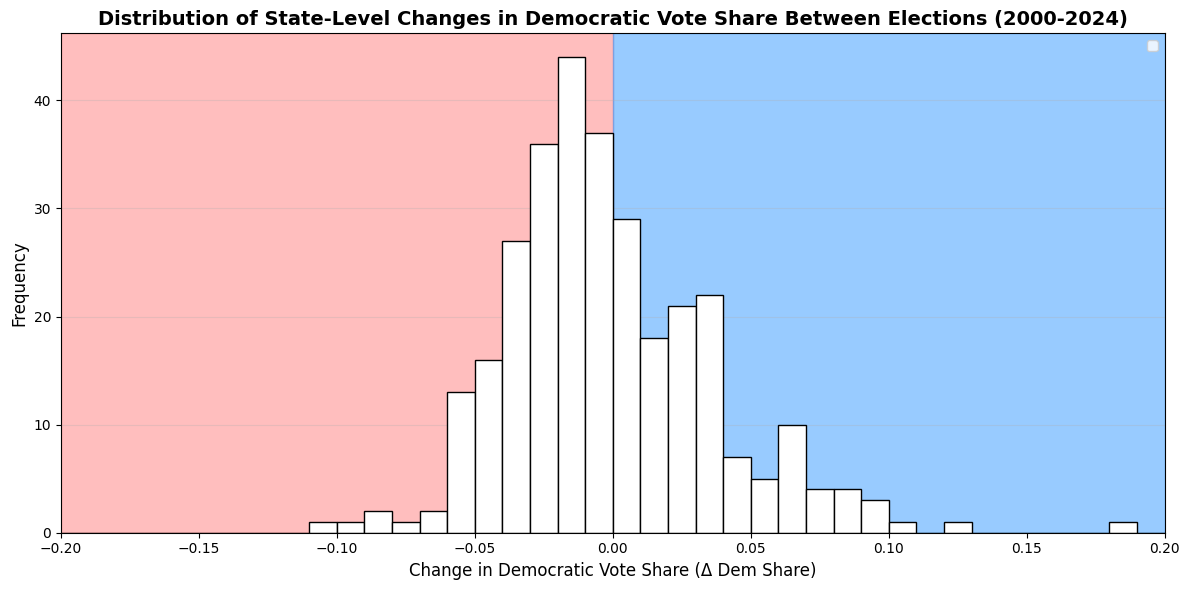

Summary statistics for vote share changes (full data):
Mean: -0.0011
Std Dev: 0.0377
Min: -0.1010
Max: 0.1860
Median: -0.0080


In [29]:
# Calculate change in Democratic vote share between consecutive elections by state
state_votes_sorted = state_votes.sort_values(['state', 'year']).reset_index(drop=True)

# Group by state and calculate the difference between consecutive years
vote_changes = []
for state in state_votes_sorted['state'].unique():
    state_data = state_votes_sorted[state_votes_sorted['state'] == state].reset_index(drop=True)
    for i in range(1, len(state_data)):
        change = state_data.loc[i, 'dem_share'] - state_data.loc[i-1, 'dem_share']
        vote_changes.append(change)

vote_changes = np.array(vote_changes)

# Only display changes from -20% to 20%
xmin, xmax = -0.2, 0.2

# Create histogram
plt.figure(figsize=(12, 6))

# Add colored backgrounds for negative and positive changes (clamped to [-0.2, 0.2])
plt.axvspan(xmin, 0, color='#ff7f7f', zorder=0, alpha=0.5)  # red for swing to R
plt.axvspan(0, xmax, color='#3399ff', zorder=0, alpha=0.5)   # blue for swing to D

# Plot histogram, restrict to changes in [-0.2, 0.2]
in_range = (vote_changes >= xmin) & (vote_changes <= xmax)
plt.hist(vote_changes[in_range], bins=40, color='white', edgecolor='black', alpha=1.0, zorder=2, range=(xmin, xmax))

plt.xlabel('Change in Democratic Vote Share (Δ Dem Share)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of State-Level Changes in Democratic Vote Share Between Elections (2000-2024)', fontsize=14, fontweight='bold')
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2, label='No change')
# plt.axvline(x=np.mean(vote_changes), color='green', linestyle='-', linewidth=2, label=f'Mean = {np.mean(vote_changes):.4f}')

plt.xlim(xmin, xmax)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Summary statistics for vote share changes (full data):")
print(f"Mean: {np.mean(vote_changes):.4f}")
print(f"Std Dev: {np.std(vote_changes):.4f}")
print(f"Min: {np.min(vote_changes):.4f}")
print(f"Max: {np.max(vote_changes):.4f}")
print(f"Median: {np.median(vote_changes):.4f}")

Data points in range [-0.2, 0.2]: 306 out of 306

Method-of-moments estimates:
a_0 = 13.427, b_0 = 13.572
Maximum likelihood estimates:
a_MLE = 12.276, b_MLE = 12.324


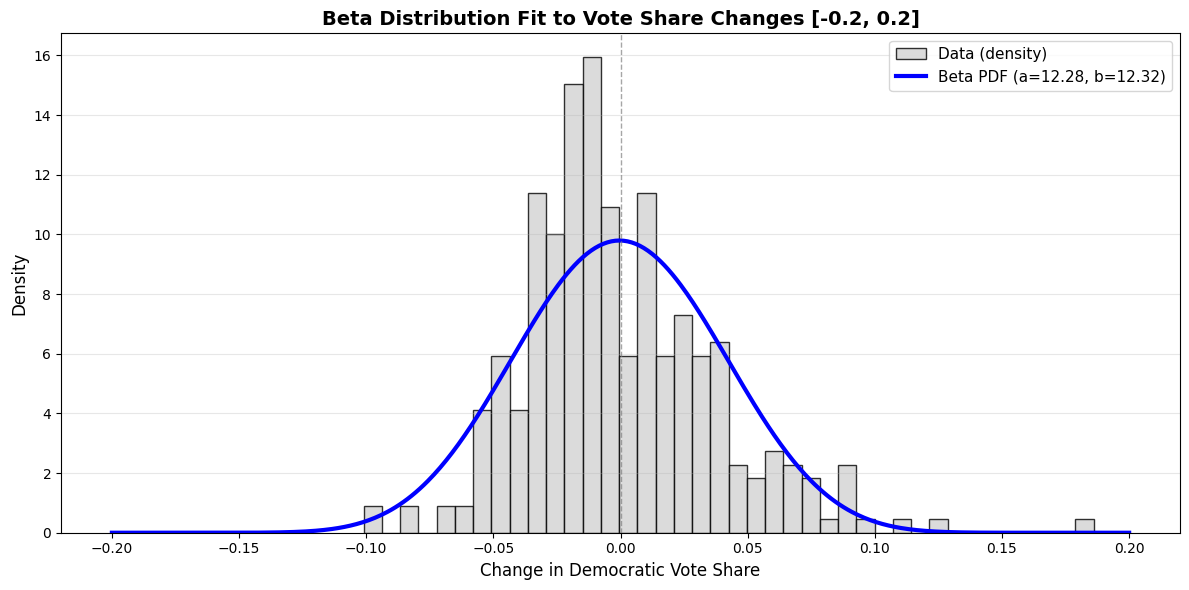

In [30]:
from scipy.stats import beta
from scipy.optimize import minimize
import numpy as np

# Filter vote_changes to be within [-0.2, 0.2]
filtered_changes = vote_changes[(vote_changes >= -0.2) & (vote_changes <= 0.2)]

print(f"Data points in range [-0.2, 0.2]: {len(filtered_changes)} out of {len(vote_changes)}")

# Transform data from [-0.2, 0.2] to [0, 1] for Beta distribution
# Using transformation: y = (x + 0.2) / 0.4
transformed_data = (filtered_changes + 0.2) / 0.4

# Remove any edge cases (should be none, but just in case)
eps = 1e-7
transformed_data = np.clip(transformed_data, eps, 1 - eps)

# Calculate mean and variance
mean_x = np.mean(transformed_data)
var_x = np.var(transformed_data, ddof=1)

# Method of moments estimates
common = mean_x * (1 - mean_x) / var_x - 1
a0 = mean_x * common
b0 = (1 - mean_x) * common

print("\nMethod-of-moments estimates:")
print(f"a_0 = {a0:.3f}, b_0 = {b0:.3f}")

# Maximum likelihood estimation
def neg_log_likelihood(params):
    a, b = params
    if a <= 0 or b <= 0:
        return np.inf
    return -np.sum(beta.logpdf(transformed_data, a, b))

res = minimize(neg_log_likelihood, [a0, b0], bounds=[(1e-4, None), (1e-4, None)])
a_mle, b_mle = res.x

print("Maximum likelihood estimates:")
print(f"a_MLE = {a_mle:.3f}, b_MLE = {b_mle:.3f}")

# Plot the fitted beta PDF
x_transformed = np.linspace(0, 1, 500)
pdf = beta.pdf(x_transformed, a_mle, b_mle)

# Transform back to original scale for visualization
x_original = x_transformed * 0.4 - 0.2

plt.figure(figsize=(12, 6))

# Plot histogram of transformed data (on original scale)
plt.hist(filtered_changes, bins=40, density=True, color="lightgray", 
         edgecolor="black", alpha=0.8, label="Data (density)")

# Plot fitted PDF
plt.plot(x_original, pdf / 0.4, 'b-', lw=3, 
         label=f"Beta PDF (a={a_mle:.2f}, b={b_mle:.2f})")

plt.xlabel('Change in Democratic Vote Share', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Beta Distribution Fit to Vote Share Changes [-0.2, 0.2]', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Great, we've gotten ballpark values. Let's say we start with values 12.5 for both a and b. Also I noticed just now that $a$ is the value that the Democrats have control of and $b$ is the value that the Republicans have control of. We'll proceed with that in mind

Number of observations: 40
Turnout change range: [-0.0802, 0.0956]
Transformed data range: [0.2995, 0.7390]

OPTIMIZED PARAMETERS

Democratic parameter (a):
  a(D) = 12.5000 + 0.0193*D + 1.6158*ln(D+1)

Republican parameter (b):
  b(R) = 12.5000 + 0.0000*R + 2.4555*ln(R+1)

Final negative log-likelihood: -46.0838
Optimization success: True


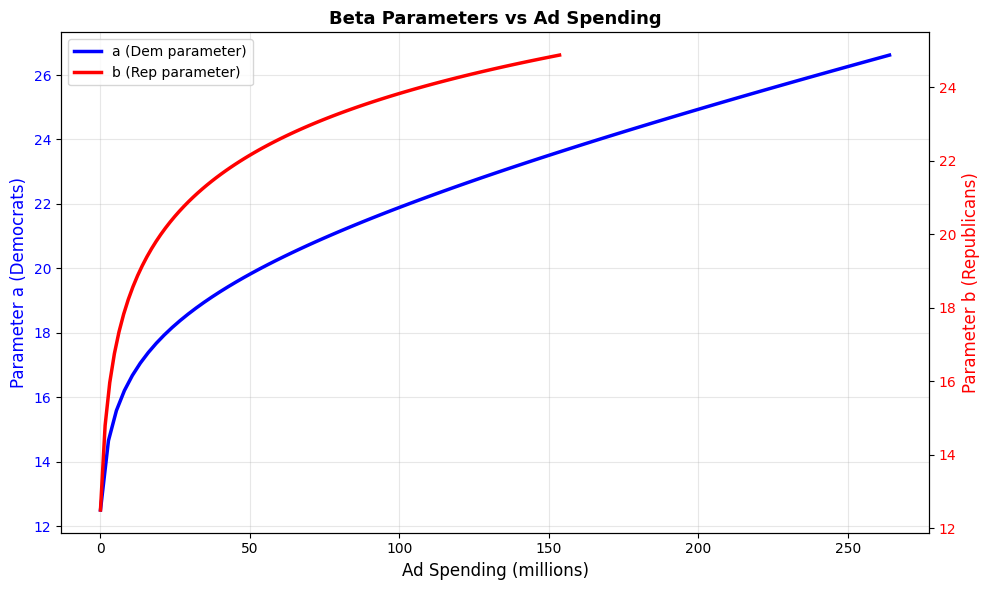

In [31]:
# Prepare the data for fitting
# Combine all years' data
all_years_data = []
for df, year in [(df_2012, 2012), (df_2016, 2016), (df_2020, 2020), (df_2024, 2024)]:
    df['year'] = year
    all_years_data.append(df)

combined_ad_data = pd.concat(all_years_data, ignore_index=True)

# Extract the relevant columns
D_spending = combined_ad_data['D-ad-spending'].values
R_spending = combined_ad_data['R-ad-spending'].values
turnout_change = (combined_ad_data['Turnout (D)'] - combined_ad_data['Prior-Turnout (D)']) / 100  # Convert to decimal

# Handle any NaN values
valid_idx = ~(np.isnan(D_spending) | np.isnan(R_spending) | np.isnan(turnout_change))
D_spending = D_spending[valid_idx]
R_spending = R_spending[valid_idx]
turnout_change = turnout_change[valid_idx]

# Transform turnout change from [-0.2, 0.2] to [0, 1] for Beta distribution
# y = (x + 0.2) / 0.4
lower, upper = -0.2, 0.2

transformed_data = (turnout_change - lower) / (upper - lower)

# Slightly clip to avoid boundary issues in Beta logpdf
eps = 1e-7
transformed_data = np.clip(transformed_data, eps, 1 - eps)

print(f"Number of observations: {len(D_spending)}")
print(f"Turnout change range: [{np.min(turnout_change):.4f}, {np.max(turnout_change):.4f}]")
print(f"Transformed data range: [{np.min(transformed_data):.4f}, {np.max(transformed_data):.4f}]")

# Remove x**2 terms! Now:
# a = g(D) = a0 + a1*D + a2*log(D+1)
# b = h(R) = b0 + b1*R + b2*log(R+1)

def g(D, a0, a1, a2):
    return a0 + a1 * D + a2 * np.log(D + 1)

def h(R, b0, b1, b2):
    return b0 + b1 * R + b2 * np.log(R + 1)

# Likelihood function to maximize
def neg_log_likelihood(params):
    a0, a1, a2, b0, b1, b2 = params

    # Compute a and b for each observation
    a_vals = g(D_spending, a0, a1, a2)
    b_vals = h(R_spending, b0, b1, b2)
    
    # Ensure a and b are positive (Beta requires a, b > 0)
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e10
    
    # Compute log-likelihood
    ll = np.sum(beta.logpdf(transformed_data, a_vals, b_vals))
    
    return -ll  # Negative because we're minimizing

# Fix a0 = 12.5 and b0 = 12.5, optimize only the remaining parameters
a0_fixed = 12.5
b0_fixed = 12.5
# a0_fixed = 5
# b0_fixed = 5

def neg_log_likelihood_fixed(params):
    # params: a1, a2, b1, b2
    a1, a2, b1, b2 = params

    # Compute a and b for each observation
    a_vals = a0_fixed + a1 * D_spending + a2 * np.log(D_spending + 1)
    b_vals = b0_fixed + b1 * R_spending + b2 * np.log(R_spending + 1)
    
    # Ensure a and b are positive (Beta requires a, b > 0)
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e10
    
    # Compute log-likelihood
    ll = np.sum(beta.logpdf(transformed_data, a_vals, b_vals))
    
    return -ll  # Negative because we're minimizing

# Initial guess for the 4 remaining parameters
initial_params = [0.01, 0.5, 0.01, 0.5]

# Bounds: require non-negativity
bounds = [
    (0, 100),       # a1: linear term for D spending
    (0, 100),       # a2: log term for D spending
    (0, 100),       # b1: linear term for R spending
    (0, 100),       # b2: log term for R spending
]

# Optimize
result = minimize(neg_log_likelihood_fixed, initial_params, bounds=bounds, method='L-BFGS-B')

a1_opt, a2_opt, b1_opt, b2_opt = result.x
a0_opt = a0_fixed
b0_opt = b0_fixed

print("\n" + "="*60)
print("OPTIMIZED PARAMETERS")
print("="*60)
print(f"\nDemocratic parameter (a):")
print(f"  a(D) = {a0_opt:.4f} + {a1_opt:.4f}*D + {a2_opt:.4f}*ln(D+1)")
print(f"\nRepublican parameter (b):")
print(f"  b(R) = {b0_opt:.4f} + {b1_opt:.4f}*R + {b2_opt:.4f}*ln(R+1)")
print(f"\nFinal negative log-likelihood: {result.fun:.4f}")
print(f"Optimization success: {result.success}")

# Visualize the fit
fig, ax = plt.subplots(figsize=(10, 6))

# Ad spending effect on parameters
D_range = np.linspace(0, np.max(D_spending) * 1.2, 100)
R_range = np.linspace(0, np.max(R_spending) * 1.2, 100)

a_range = a0_opt + a1_opt * D_range + a2_opt * np.log(D_range + 1)
b_range = b0_opt + b1_opt * R_range + b2_opt * np.log(R_range + 1)

ax_a = ax
ax_b = ax.twinx()

line_a = ax_a.plot(D_range, a_range, 'b-', lw=2.5, label='a (Dem parameter)')
line_b = ax_b.plot(R_range, b_range, 'r-', lw=2.5, label='b (Rep parameter)')

ax_a.set_xlabel('Ad Spending (millions)', fontsize=12)
ax_a.set_ylabel('Parameter a (Democrats)', fontsize=12, color='b')
ax_b.set_ylabel('Parameter b (Republicans)', fontsize=12, color='r')
ax_a.tick_params(axis='y', labelcolor='b')
ax_b.tick_params(axis='y', labelcolor='r')
ax_a.set_title('Beta Parameters vs Ad Spending', fontsize=13, fontweight='bold')
ax_a.grid(True, alpha=0.3)

lines = line_a + line_b
labels = [l.get_label() for l in lines]
ax_a.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

Number of observations: 40
Turnout change range: [-0.0802, 0.0956]
D spending range: [0.10, 220.00] million
R spending range: [0.20, 128.00] million
Population range: [693,328, 13,932,700] voters
Transformed data range: [0.2995, 0.7390]

FITTING POPULATION-SCALED MODEL

OPTIMIZED PARAMETERS

Democratic parameter (a):
  a = 12.5000 + (1/population) * [1.00e+06*D + 1.00e+06*ln(D+1)]

Republican parameter (b):
  b = 12.5000 + (1/population) * [1.00e+06*R + 1.00e+06*ln(R+1)]

Final negative log-likelihood: -18.3744
Optimization success: True

PARAMETER RANGES
a ranges from 12.78 to 51.97
b ranges from 13.04 to 51.97

This is a 39.2 point range for a
and a 38.9 point range for b


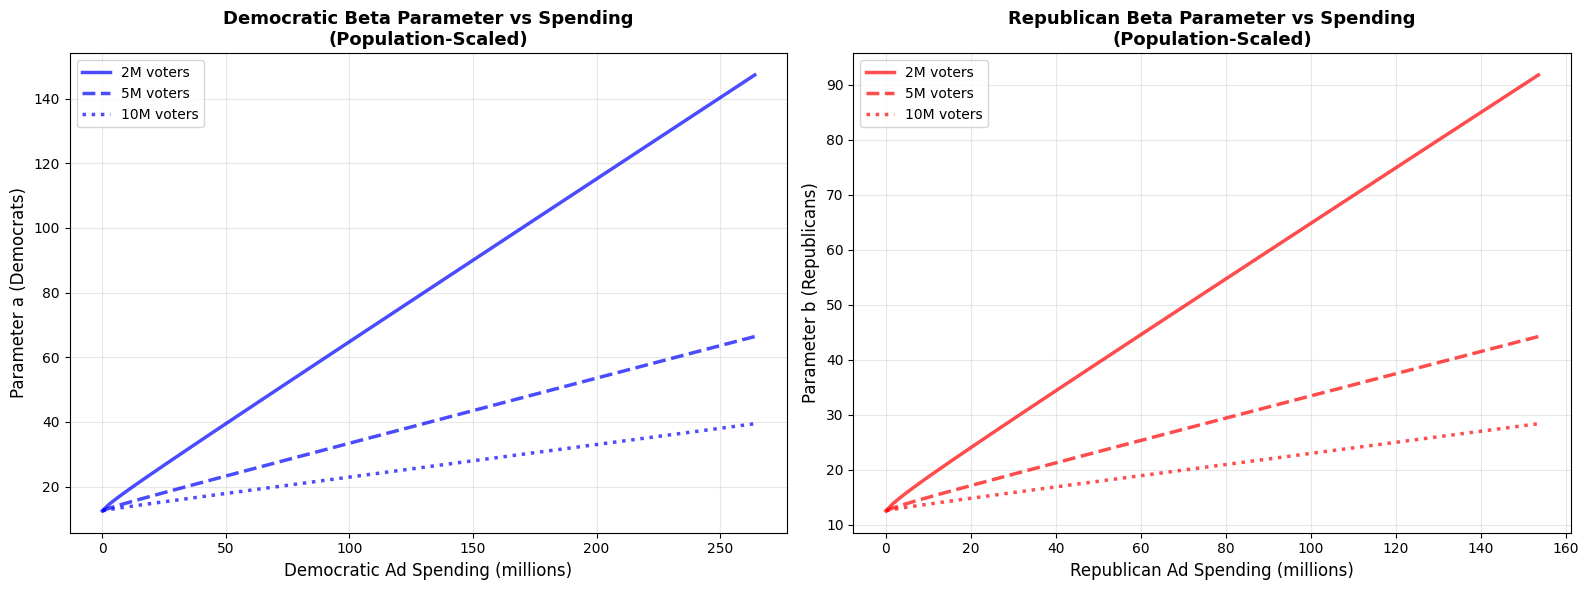

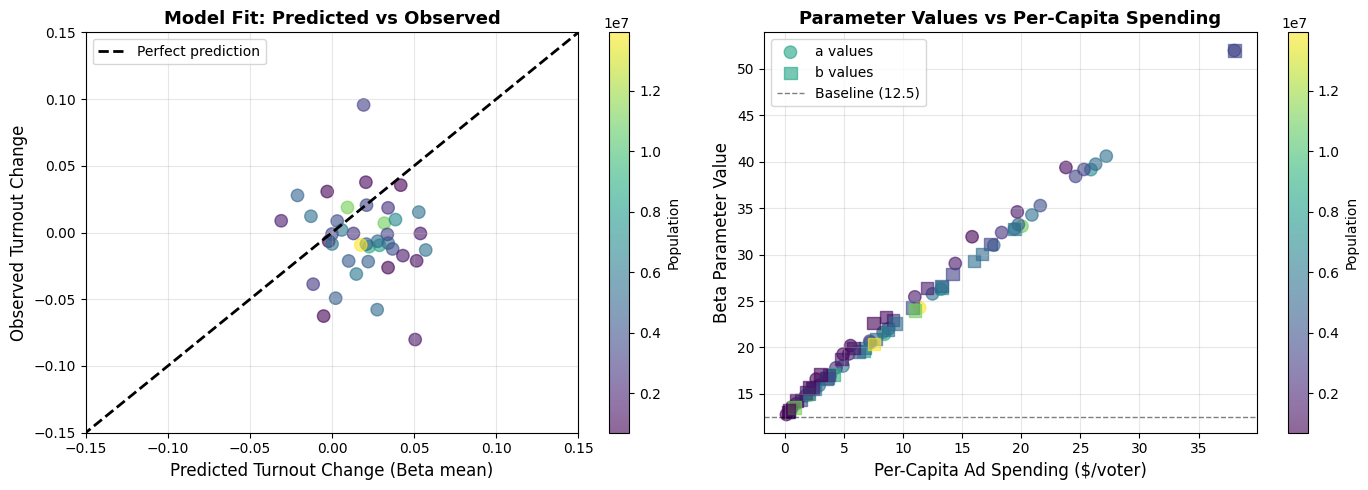

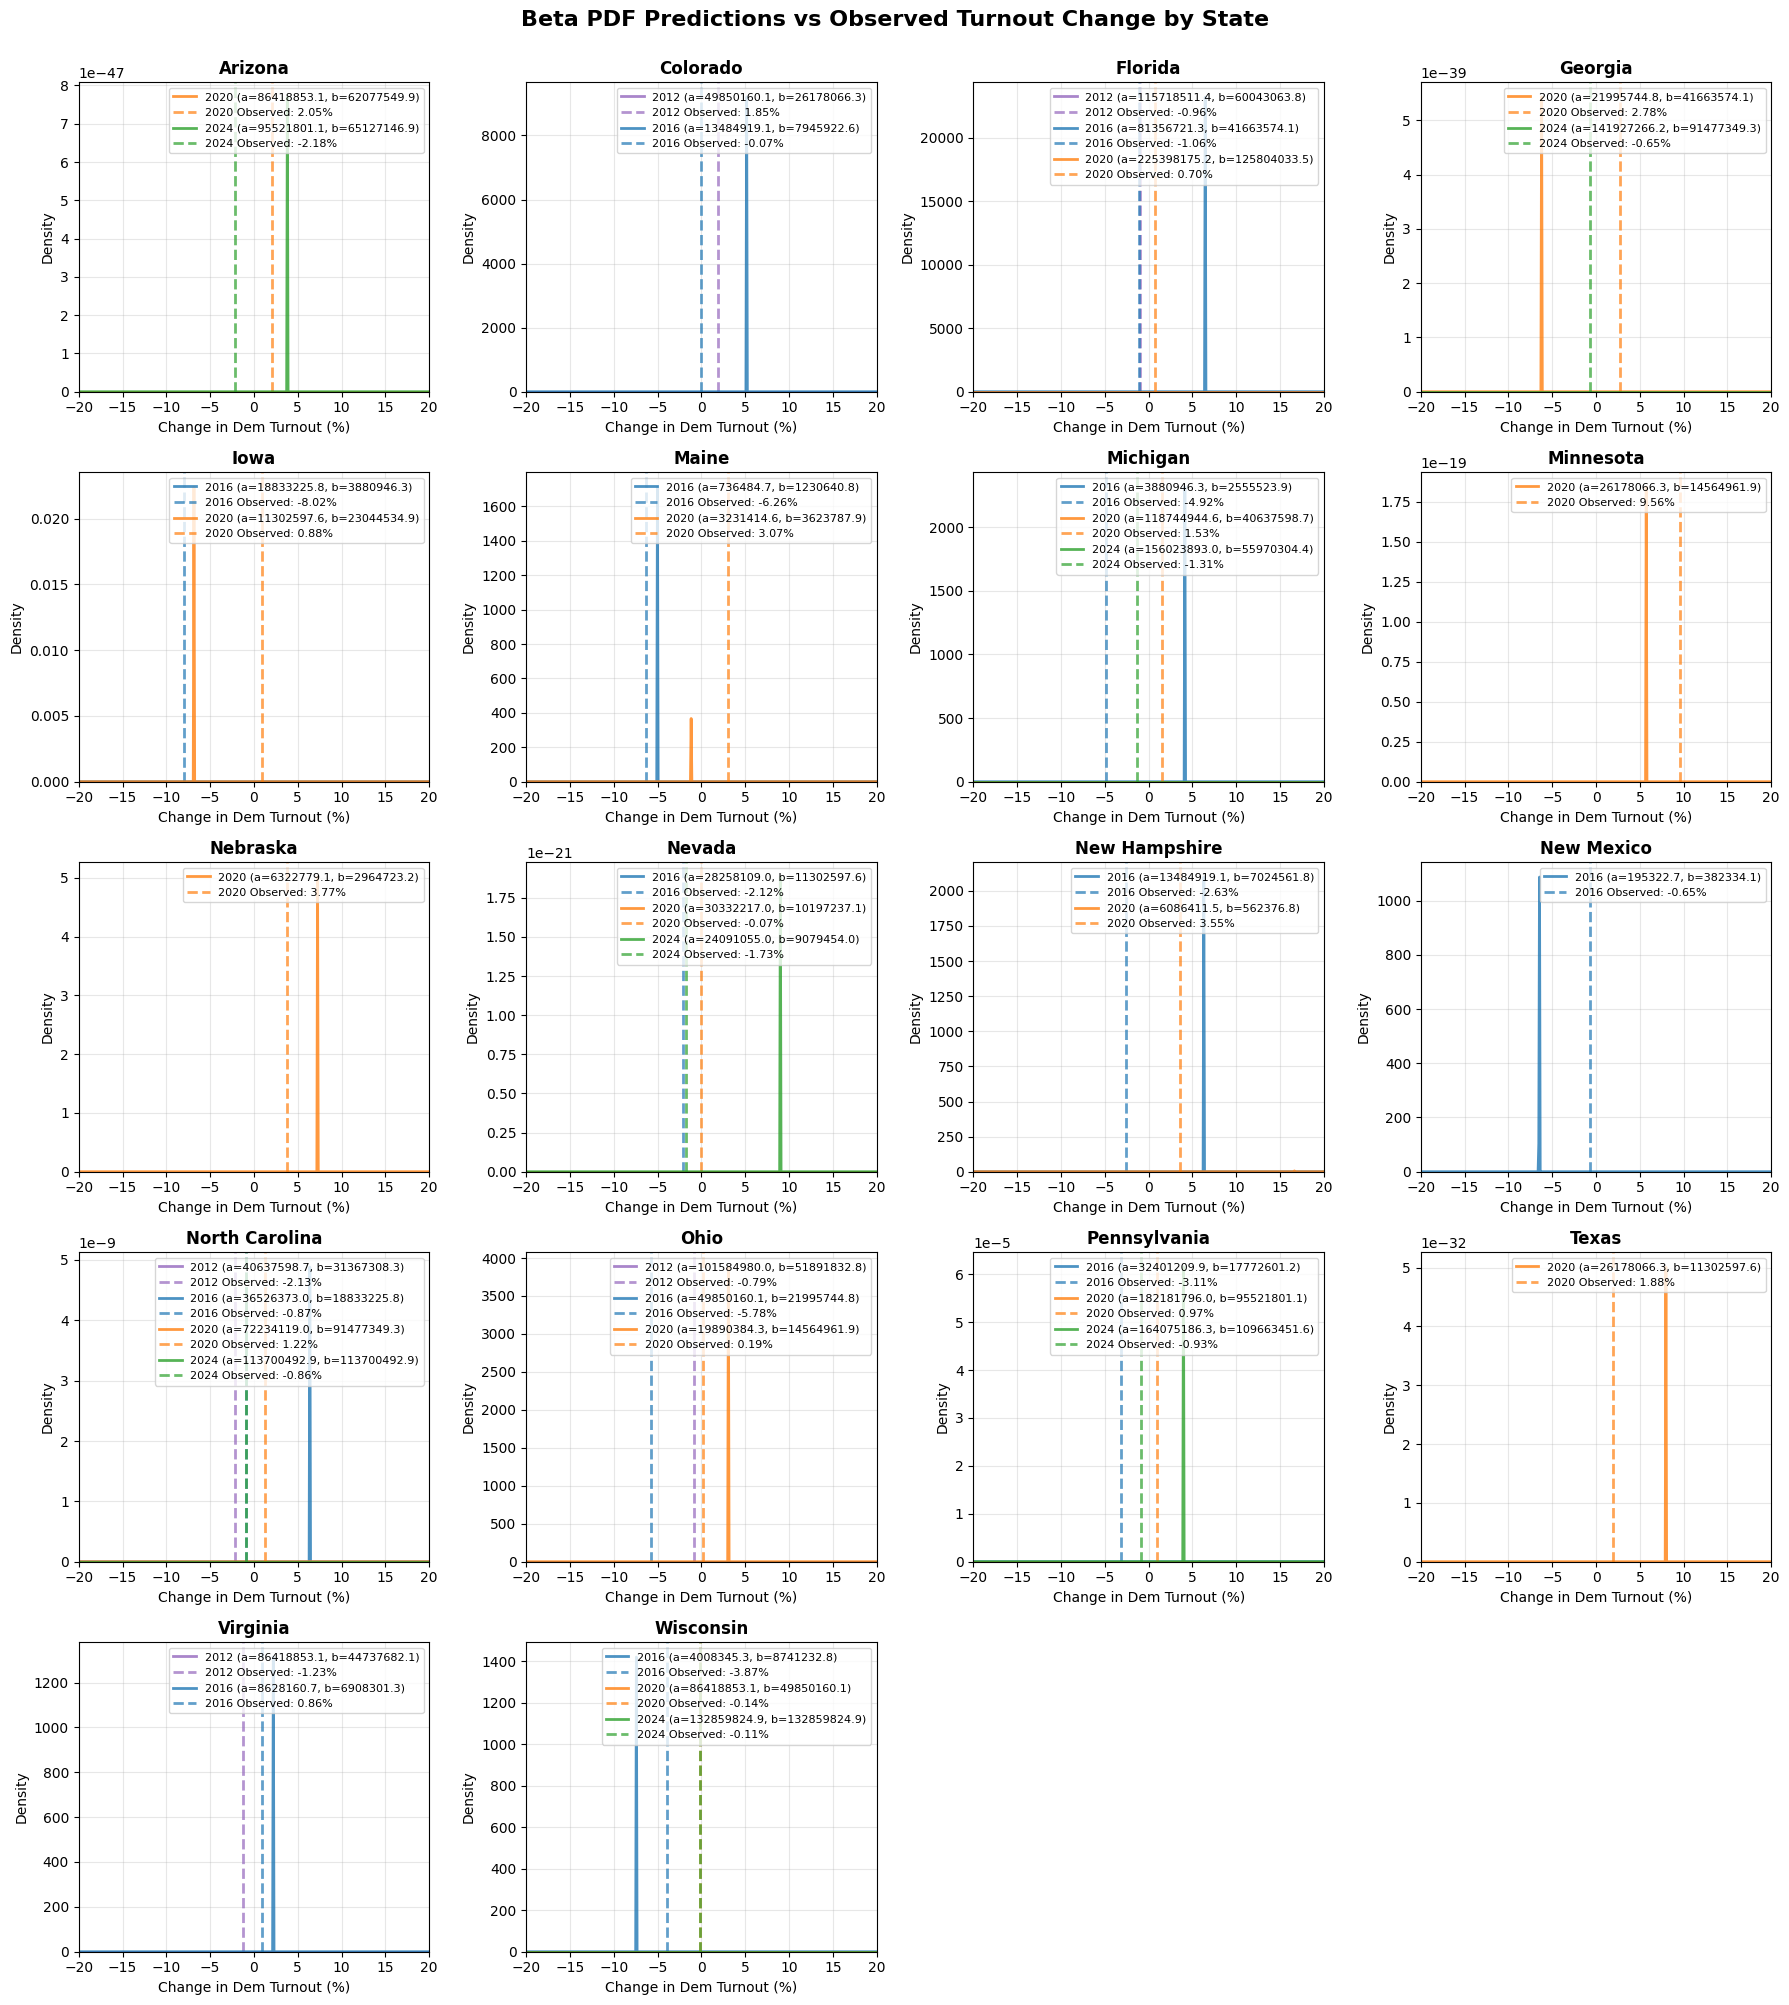


State-Year Summary:
             State  Year  D-ad-spending  R-ad-spending             a             b  Turnout_Change
0          Arizona  2020           82.0           58.0  8.641885e+07  6.207755e+07          0.0205
1          Arizona  2024           91.0           61.0  9.552180e+07  6.512715e+07         -0.0218
2         Colorado  2012           46.0           23.0  4.985016e+07  2.617807e+07          0.0185
3         Colorado  2016           11.0            6.0  1.348492e+07  7.945923e+06         -0.0007
4          Florida  2012          111.0           56.0  1.157185e+08  6.004306e+07         -0.0096
5          Florida  2016           77.0           38.0  8.135672e+07  4.166357e+07         -0.0106
6          Florida  2020          220.0          121.0  2.253982e+08  1.258040e+08          0.0070
7          Georgia  2020           19.0           38.0  2.199574e+07  4.166357e+07          0.0278
8          Georgia  2024          137.0           87.0  1.419273e+08  9.147735e+07      

In [32]:
# Combine all years' data with state information
all_data = []
for df, year in [(df_2012, 2012), (df_2016, 2016), (df_2020, 2020), (df_2024, 2024)]:
    df_copy = df.copy()
    df_copy['Year'] = year
    all_data.append(df_copy)

state_data = pd.concat(all_data, ignore_index=True)

# Get unique state-year combinations
state_years = state_data[['State', 'Year', 'D-ad-spending', 'R-ad-spending',
                          'Turnout (D)', 'Prior-Turnout (D)']].drop_duplicates()
state_years = state_years.sort_values(['State', 'Year']).reset_index(drop=True)

# Calculate a and b for each state-year (USE THE FULL MODEL)import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')
ad_df = pd.read_csv('ad_data.csv')

# Get state-level vote counts by year (only DEMOCRAT and REPUBLICAN)
state_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()
state_votes['total_partisan'] = state_votes['DEMOCRAT'] + state_votes['REPUBLICAN']

# Standardize state names for merge
state_votes['state'] = state_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge on year, state to get population
combined_data = ad_df.merge(
    state_votes[['year', 'state', 'total_partisan']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='inner'
)

# Calculate turnout change (already in [-0.2, 0.2])
combined_data['turnout_change'] = (combined_data['Turnout (D)'] - combined_data['Prior-Turnout (D)']) / 100

# Remove rows with missing data
combined_data = combined_data.dropna(subset=['D-ad-spending', 'R-ad-spending', 'turnout_change', 'total_partisan'])

# Extract arrays just like @file_context_0
D_spending = combined_data['D-ad-spending'].values
R_spending = combined_data['R-ad-spending'].values
turnout_change = combined_data['turnout_change'].values
total_partisan = combined_data['total_partisan'].values

# Just use turnout_change as observed, in [-0.2, 0.2]
print(f"Number of observations: {len(D_spending)}")
print(f"Turnout change range: [{np.min(turnout_change):.4f}, {np.max(turnout_change):.4f}]")
print(f"D spending range: [{np.min(D_spending):.2f}, {np.max(D_spending):.2f}] million")
print(f"R spending range: [{np.min(R_spending):.2f}, {np.max(R_spending):.2f}] million")
print(f"Population range: [{np.min(total_partisan):,.0f}, {np.max(total_partisan):,.0f}] voters")

# Transform turnout_change to [0, 1] for Beta only internally (for likelihood etc)
lower, upper = -0.2, 0.2
transformed_data = (turnout_change - lower) / (upper - lower)
eps = 1e-7
transformed_data = np.clip(transformed_data, eps, 1 - eps)

print(f"Transformed data range: [{np.min(transformed_data):.4f}, {np.max(transformed_data):.4f}]")

# Population-scaled Beta parameter model as in @file_context_0
def g(D, a1, a2):
    # Function of raw spending (millions) for Democrats
    return a1 * D + a2 * np.log(D + 1)

def h(R, b1, b2):
    # Function of raw spending (millions) for Republicans
    return b1 * R + b2 * np.log(R + 1)

# Fixed baseline
a0_fixed = 12.5
b0_fixed = 12.5

def neg_log_likelihood_population_scaled(params):
    # params: a1, a2, b1, b2
    a1, a2, b1, b2 = params
    # ensure positiveness
    if a1 < 0 or a2 < 0 or b1 < 0 or b2 < 0:
        return 1e12
    a_vals = a0_fixed + (1.0 / total_partisan) * g(D_spending, a1, a2)
    b_vals = b0_fixed + (1.0 / total_partisan) * h(R_spending, b1, b2)
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e12
    ll = np.sum(beta.logpdf(transformed_data, a_vals, b_vals))
    return -ll

# Initial guess
initial_params = [1e6, 1e6, 1e6, 1e6]
bounds = [
    (0, 1e8),   # a1: linear term for D spending
    (0, 1e8),   # a2: log term for D spending
    (0, 1e8),   # b1: linear term for R spending
    (0, 1e8),   # b2: log term for R spending
]

print("\n" + "="*60)
print("FITTING POPULATION-SCALED MODEL")
print("="*60)

result = minimize(neg_log_likelihood_population_scaled, initial_params, bounds=bounds, method='L-BFGS-B')

a1_opt, a2_opt, b1_opt, b2_opt = result.x
a0_opt = a0_fixed
b0_opt = b0_fixed

print("\n" + "="*60)
print("OPTIMIZED PARAMETERS")
print("="*60)
print(f"\nDemocratic parameter (a):")
print(f"  a = {a0_opt:.4f} + (1/population) * [{a1_opt:.2e}*D + {a2_opt:.2e}*ln(D+1)]")
print(f"\nRepublican parameter (b):")
print(f"  b = {b0_opt:.4f} + (1/population) * [{b1_opt:.2e}*R + {b2_opt:.2e}*ln(R+1)]")
print(f"\nFinal negative log-likelihood: {result.fun:.4f}")
print(f"Optimization success: {result.success}")

# Fitted parameter values for observed states
a_fitted = a0_fixed + (1.0 / total_partisan) * g(D_spending, a1_opt, a2_opt)
b_fitted = b0_fixed + (1.0 / total_partisan) * h(R_spending, b1_opt, b2_opt)

print("\n" + "="*60)
print("PARAMETER RANGES")
print("="*60)
print(f"a ranges from {a_fitted.min():.2f} to {a_fitted.max():.2f}")
print(f"b ranges from {b_fitted.min():.2f} to {b_fitted.max():.2f}")
print(f"\nThis is a {a_fitted.max() - a_fitted.min():.1f} point range for a")
print(f"and a {b_fitted.max() - b_fitted.min():.1f} point range for b")

# Visualize the fit for different population sizes like in the original context
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pop_small = 2e6
pop_medium = 5e6
pop_large = 10e6

D_range = np.linspace(0, np.max(D_spending) * 1.2, 100)
R_range = np.linspace(0, np.max(R_spending) * 1.2, 100)

for pop, label, style in [(pop_small, '2M voters', '-'), (pop_medium, '5M voters', '--'), (pop_large, '10M voters', ':')]:
    a_curve = a0_opt + (1.0 / pop) * g(D_range, a1_opt, a2_opt)
    axes[0].plot(D_range, a_curve, 'b' + style, lw=2.5, label=label, alpha=0.7)
axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=12)
axes[0].set_ylabel('Parameter a (Democrats)', fontsize=12)
axes[0].set_title('Democratic Beta Parameter vs Spending\n(Population-Scaled)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for pop, label, style in [(pop_small, '2M voters', '-'), (pop_medium, '5M voters', '--'), (pop_large, '10M voters', ':')]:
    b_curve = b0_opt + (1.0 / pop) * h(R_range, b1_opt, b2_opt)
    axes[1].plot(R_range, b_curve, 'r' + style, lw=2.5, label=label, alpha=0.7)
axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=12)
axes[1].set_ylabel('Parameter b (Republicans)', fontsize=12)
axes[1].set_title('Republican Beta Parameter vs Spending\n(Population-Scaled)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Diagnostic plots: fit vs observed and per-capita spending vs a/b
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compute predicted mean in the [-0.2, 0.2] range (original units)
predicted_mean_transformed = a_fitted / (a_fitted + b_fitted)
predicted_mean = predicted_mean_transformed * (upper - lower) + lower

axes[0].scatter(predicted_mean, turnout_change, alpha=0.6, s=80, c=total_partisan, cmap='viridis')
axes[0].plot([-0.2, 0.2], [-0.2, 0.2], 'k--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Predicted Turnout Change (Beta mean)', fontsize=12)
axes[0].set_ylabel('Observed Turnout Change', fontsize=12)
axes[0].set_title('Model Fit: Predicted vs Observed', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-0.15, 0.15)
axes[0].set_ylim(-0.15, 0.15)
cbar0 = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar0.set_label('Population', fontsize=10)

D_per_capita = D_spending * 1e6 / total_partisan
R_per_capita = R_spending * 1e6 / total_partisan

sc = axes[1].scatter(D_per_capita, a_fitted, alpha=0.6, s=80, c=total_partisan, cmap='viridis', label='a values')
axes[1].scatter(R_per_capita, b_fitted, alpha=0.6, s=80, c=total_partisan, cmap='viridis', marker='s', label='b values')
axes[1].axhline(y=12.5, color='k', linestyle='--', lw=1, alpha=0.5, label='Baseline (12.5)')
axes[1].set_xlabel('Per-Capita Ad Spending ($/voter)', fontsize=12)
axes[1].set_ylabel('Beta Parameter Value', fontsize=12)
axes[1].set_title('Parameter Values vs Per-Capita Spending', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
cbar1 = plt.colorbar(sc, ax=axes[1])
cbar1.set_label('Population', fontsize=10)

plt.tight_layout()
plt.show()
state_years['a'] = (
    a0_opt
    + a1_opt * state_years['D-ad-spending']
    + a2_opt * np.log(state_years['D-ad-spending'] + 1)
)

state_years['b'] = (
    b0_opt
    + b1_opt * state_years['R-ad-spending']
    + b2_opt * np.log(state_years['R-ad-spending'] + 1)
)

# Turnout change (decimal)
state_years['Turnout_Change'] = (state_years['Turnout (D)'] - state_years['Prior-Turnout (D)']) / 100

# State list
unique_states = sorted(state_years['State'].unique())

# Setup subplots
n_states = len(unique_states)
n_cols = 4
n_rows = (n_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

# Correct turnout-change domain
x_range = np.linspace(-0.2, 0.2, 500)

# Correct Beta-transform (SAME as in fitting!)
# y = (x + 0.2) / 0.4
x_transformed = (x_range + 0.2) / 0.4

# Colors for each year
year_colors = {2012: '#9467bd', 2016: '#1f77b4', 2020: '#ff7f0e', 2024: '#2ca02c'}

for idx, state in enumerate(unique_states):
    ax = axes[idx]
    state_entries = state_years[state_years['State'] == state]

    for _, row in state_entries.iterrows():
        a_val = row['a']
        b_val = row['b']
        turnout_change = row['Turnout_Change']
        year = row['Year']
        color = year_colors[year]

        # Beta PDF evaluated on transformed domain
        pdf_vals = beta.pdf(x_transformed, a_val, b_val)

        # Apply Jacobian: dy/dx = 1 / 0.4 = 2.5
        pdf_vals = pdf_vals / 0.4

        # Plot Beta PDF
        ax.plot(x_range * 100, pdf_vals,
                linewidth=2, color=color,
                label=f'{year} (a={a_val:.1f}, b={b_val:.1f})',
                alpha=0.8)

        # Observed turnout-change line
        ax.axvline(x=turnout_change * 100,
                   linestyle='--', linewidth=2,
                   alpha=0.7, color=color,
                   label=f'{year} Observed: {turnout_change*100:.2f}%')

    ax.set_xlim(-20, 20)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Change in Dem Turnout (%)', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{state}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_states, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Beta PDF Predictions vs Observed Turnout Change by State',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Summary table
print("\nState-Year Summary:")
print(state_years[['State', 'Year', 'D-ad-spending', 'R-ad-spending', 'a', 'b', 'Turnout_Change']].to_string())


Okay let's try leaving the constant term open

Number of observations: 40
Turnout change range: [-0.0802, 0.0956]
Transformed data range: [0.2995, 0.7390]

OPTIMIZED PARAMETERS

Democratic parameter (a):
  a(D) = 16.0197 + 0.0084*D + 1.3890*ln(D+1)

Republican parameter (b):
  b(R) = 18.7144 + 0.0162*R + 0.9572*ln(R+1)

Final negative log-likelihood: -46.7324
Optimization success: True


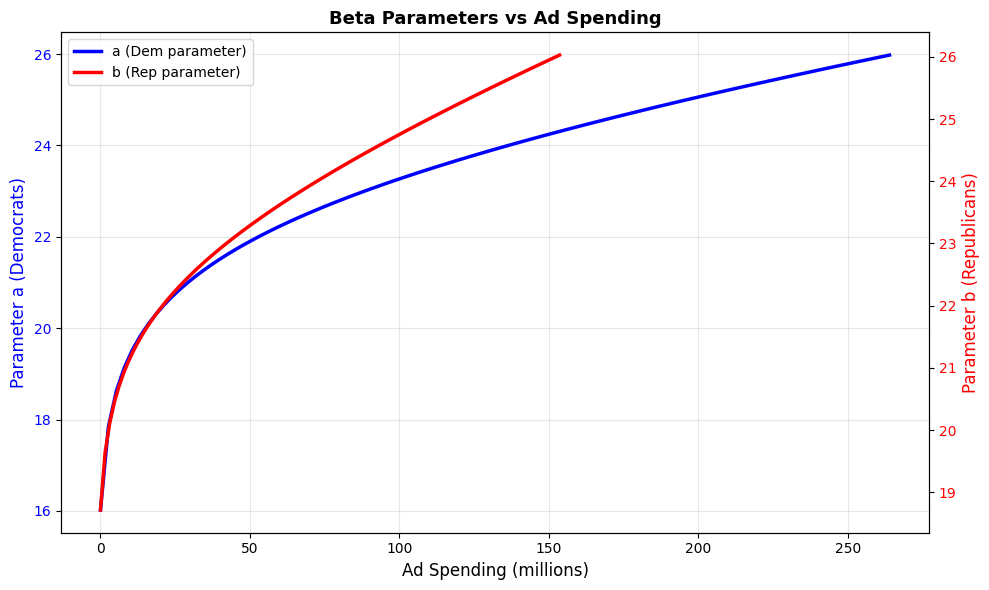

In [33]:
# Prepare the data for fitting
# Combine all years' data
all_years_data = []
for df, year in [(df_2012, 2012), (df_2016, 2016), (df_2020, 2020), (df_2024, 2024)]:
    df['year'] = year
    all_years_data.append(df)

combined_ad_data = pd.concat(all_years_data, ignore_index=True)

# Extract the relevant columns
D_spending = combined_ad_data['D-ad-spending'].values
R_spending = combined_ad_data['R-ad-spending'].values
turnout_change = (combined_ad_data['Turnout (D)'] - combined_ad_data['Prior-Turnout (D)']) / 100  # Convert to decimal

# Handle any NaN values
valid_idx = ~(np.isnan(D_spending) | np.isnan(R_spending) | np.isnan(turnout_change))
D_spending = D_spending[valid_idx]
R_spending = R_spending[valid_idx]
turnout_change = turnout_change[valid_idx]

# Transform turnout change from [-0.2, 0.2] to [0, 1] for Beta distribution
# y = (x + 0.2) / 0.4
lower, upper = -0.2, 0.2

transformed_data = (turnout_change - lower) / (upper - lower)

# Slightly clip to avoid boundary issues in Beta logpdf
eps = 1e-7
transformed_data = np.clip(transformed_data, eps, 1 - eps)

print(f"Number of observations: {len(D_spending)}")
print(f"Turnout change range: [{np.min(turnout_change):.4f}, {np.max(turnout_change):.4f}]")
print(f"Transformed data range: [{np.min(transformed_data):.4f}, {np.max(transformed_data):.4f}]")

# Remove x**2 terms! Now:
# a = g(D) = a0 + a1*D + a2*log(D+1)
# b = h(R) = b0 + b1*R + b2*log(R+1)

def g(D, a0, a1, a2):
    return a0 + a1 * D + a2 * np.log(D + 1)

def h(R, b0, b1, b2):
    return b0 + b1 * R + b2 * np.log(R + 1)

# Likelihood function to maximize (now with variable a0, b0)
def neg_log_likelihood(params):
    a0, a1, a2, b0, b1, b2 = params

    # Compute a and b for each observation
    a_vals = g(D_spending, a0, a1, a2)
    b_vals = h(R_spending, b0, b1, b2)
    
    # Ensure a and b are positive (Beta requires a, b > 0)
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e10
    
    # Compute log-likelihood
    ll = np.sum(beta.logpdf(transformed_data, a_vals, b_vals))
    
    return -ll  # Negative because we're minimizing

# Initial guess for the 6 parameters: [a0, a1, a2, b0, b1, b2]
initial_params = [12.5, 0.01, 0.5, 12.5, 0.01, 0.5]

# Bounds for all parameters - constant terms must be strictly > 0 (e.g. (1e-3, 100)), rest non-negative
bounds = [
    (1e-3, 100),    # a0: constant term for D
    (0, 100),       # a1: linear term for D
    (0, 100),       # a2: log term for D
    (1e-3, 100),    # b0: constant term for R
    (0, 100),       # b1: linear term for R
    (0, 100),       # b2: log term for R
]

# Optimize all parameters
result = minimize(neg_log_likelihood, initial_params, bounds=bounds, method='L-BFGS-B')

a0_opt, a1_opt, a2_opt, b0_opt, b1_opt, b2_opt = result.x

print("\n" + "="*60)
print("OPTIMIZED PARAMETERS")
print("="*60)
print(f"\nDemocratic parameter (a):")
print(f"  a(D) = {a0_opt:.4f} + {a1_opt:.4f}*D + {a2_opt:.4f}*ln(D+1)")
print(f"\nRepublican parameter (b):")
print(f"  b(R) = {b0_opt:.4f} + {b1_opt:.4f}*R + {b2_opt:.4f}*ln(R+1)")
print(f"\nFinal negative log-likelihood: {result.fun:.4f}")
print(f"Optimization success: {result.success}")

# Visualize the fit
fig, ax = plt.subplots(figsize=(10, 6))

# Ad spending effect on parameters
D_range = np.linspace(0, np.max(D_spending) * 1.2, 100)
R_range = np.linspace(0, np.max(R_spending) * 1.2, 100)

a_range = a0_opt + a1_opt * D_range + a2_opt * np.log(D_range + 1)
b_range = b0_opt + b1_opt * R_range + b2_opt * np.log(R_range + 1)

ax_a = ax
ax_b = ax.twinx()

line_a = ax_a.plot(D_range, a_range, 'b-', lw=2.5, label='a (Dem parameter)')
line_b = ax_b.plot(R_range, b_range, 'r-', lw=2.5, label='b (Rep parameter)')

ax_a.set_xlabel('Ad Spending (millions)', fontsize=12)
ax_a.set_ylabel('Parameter a (Democrats)', fontsize=12, color='b')
ax_b.set_ylabel('Parameter b (Republicans)', fontsize=12, color='r')
ax_a.tick_params(axis='y', labelcolor='b')
ax_b.tick_params(axis='y', labelcolor='r')
ax_a.set_title('Beta Parameters vs Ad Spending', fontsize=13, fontweight='bold')
ax_a.grid(True, alpha=0.3)

lines = line_a + line_b
labels = [l.get_label() for l in lines]
ax_a.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

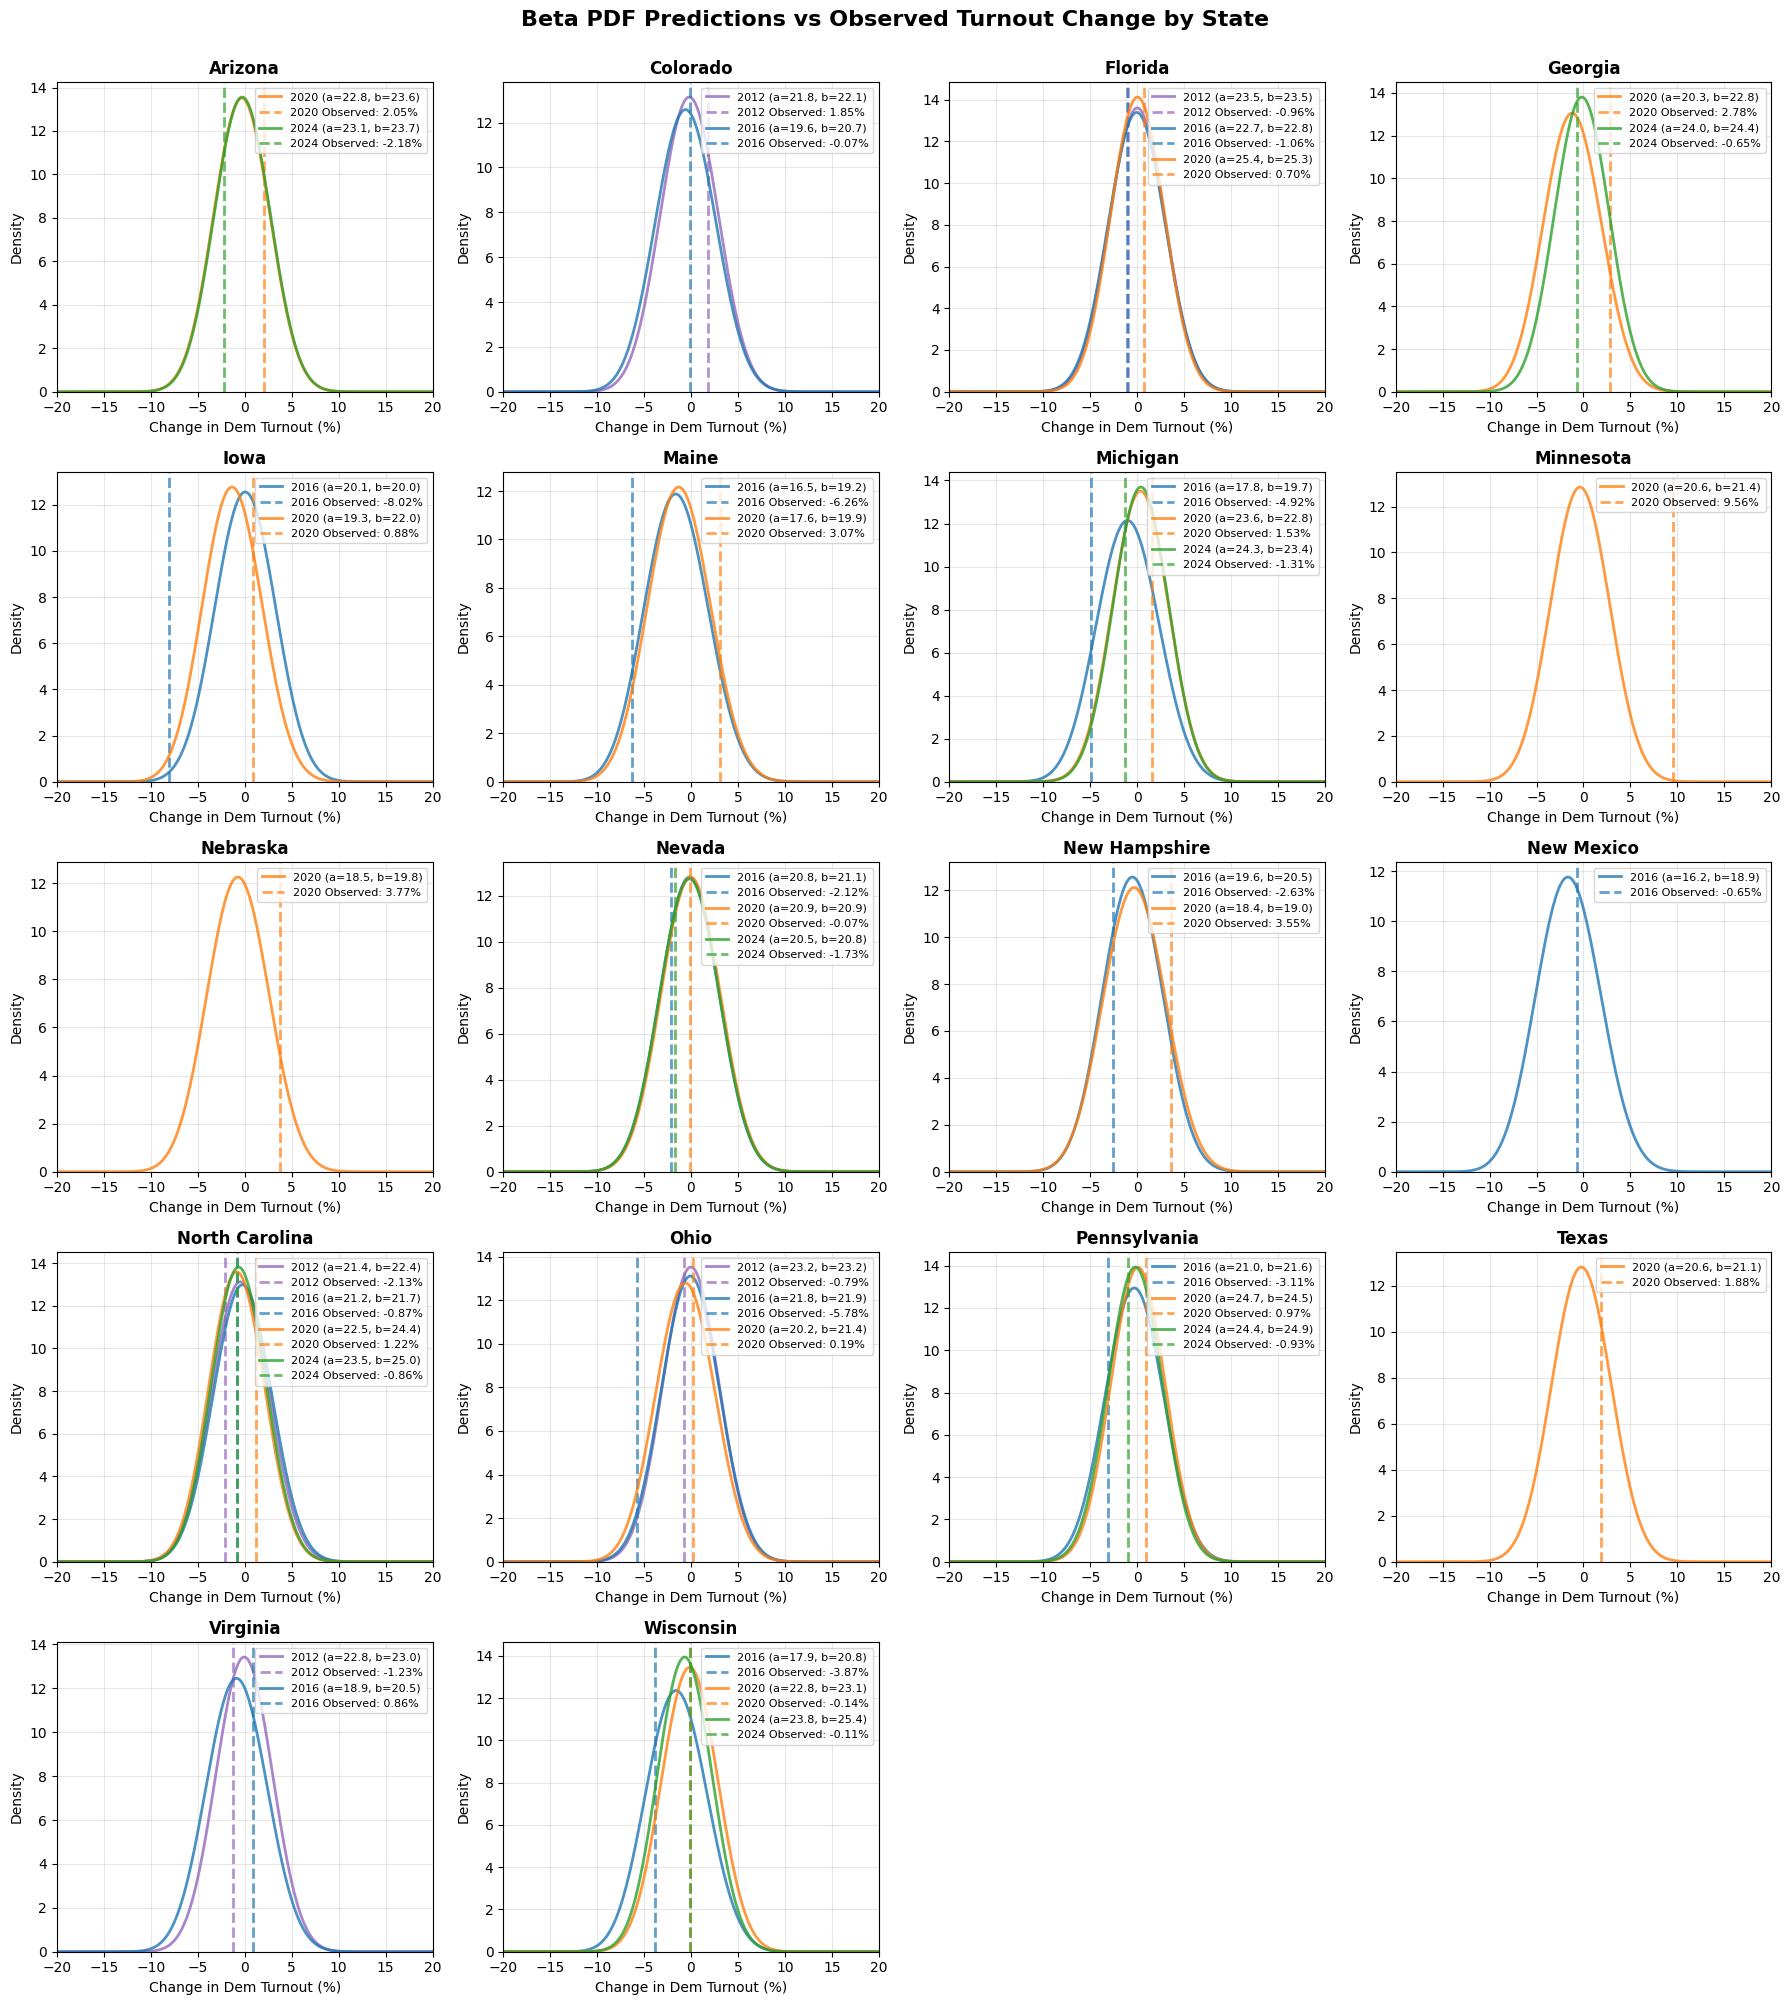


State-Year Summary:
             State  Year  D-ad-spending  R-ad-spending          a          b  Turnout_Change
0          Arizona  2020           82.0           58.0  22.842911  23.557827          0.0205
1          Arizona  2024           91.0           61.0  23.061127  23.653950         -0.0218
2         Colorado  2012           46.0           23.0  21.752106  22.129276          0.0185
3         Colorado  2016           11.0            6.0  19.563227  20.674223         -0.0007
4          Florida  2012          111.0           56.0  23.501516  23.492383         -0.0096
5          Florida  2016           77.0           38.0  22.714820  22.837242         -0.0106
6          Florida  2020          220.0          121.0  25.356567  25.274867          0.0070
7          Georgia  2020           19.0           38.0  20.339641  22.837242          0.0278
8          Georgia  2024          137.0           87.0  24.008780  24.410795         -0.0065
9             Iowa  2016           16.0          

In [34]:
# Combine all years' data with state information
all_data = []
for df, year in [(df_2012, 2012), (df_2016, 2016), (df_2020, 2020), (df_2024, 2024)]:
    df_copy = df.copy()
    df_copy['Year'] = year
    all_data.append(df_copy)

state_data = pd.concat(all_data, ignore_index=True)

# Get unique state-year combinations
state_years = state_data[['State', 'Year', 'D-ad-spending', 'R-ad-spending',
                          'Turnout (D)', 'Prior-Turnout (D)']].drop_duplicates()
state_years = state_years.sort_values(['State', 'Year']).reset_index(drop=True)

# Calculate a and b for each state-year (USE THE FULL MODEL)
state_years['a'] = (
    a0_opt
    + a1_opt * state_years['D-ad-spending']
    + a2_opt * np.log(state_years['D-ad-spending'] + 1)
)

state_years['b'] = (
    b0_opt
    + b1_opt * state_years['R-ad-spending']
    + b2_opt * np.log(state_years['R-ad-spending'] + 1)
)

# Turnout change (decimal)
state_years['Turnout_Change'] = (state_years['Turnout (D)'] - state_years['Prior-Turnout (D)']) / 100

# State list
unique_states = sorted(state_years['State'].unique())

# Setup subplots
n_states = len(unique_states)
n_cols = 4
n_rows = (n_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

# Correct turnout-change domain
x_range = np.linspace(-0.2, 0.2, 500)

# Correct Beta-transform (SAME as in fitting!)
# y = (x + 0.2) / 0.4
x_transformed = (x_range + 0.2) / 0.4

# Colors for each year
year_colors = {2012: '#9467bd', 2016: '#1f77b4', 2020: '#ff7f0e', 2024: '#2ca02c'}

for idx, state in enumerate(unique_states):
    ax = axes[idx]
    state_entries = state_years[state_years['State'] == state]

    for _, row in state_entries.iterrows():
        a_val = row['a']
        b_val = row['b']
        turnout_change = row['Turnout_Change']
        year = row['Year']
        color = year_colors[year]

        # Beta PDF evaluated on transformed domain
        pdf_vals = beta.pdf(x_transformed, a_val, b_val)

        # Apply Jacobian: dy/dx = 1 / 0.4 = 2.5
        pdf_vals = pdf_vals / 0.4

        # Plot Beta PDF
        ax.plot(x_range * 100, pdf_vals,
                linewidth=2, color=color,
                label=f'{year} (a={a_val:.1f}, b={b_val:.1f})',
                alpha=0.8)

        # Observed turnout-change line
        ax.axvline(x=turnout_change * 100,
                   linestyle='--', linewidth=2,
                   alpha=0.7, color=color,
                   label=f'{year} Observed: {turnout_change*100:.2f}%')

    ax.set_xlim(-20, 20)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Change in Dem Turnout (%)', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{state}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_states, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Beta PDF Predictions vs Observed Turnout Change by State',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Summary table
print("\nState-Year Summary:")
print(state_years[['State', 'Year', 'D-ad-spending', 'R-ad-spending', 'a', 'b', 'Turnout_Change']].to_string())


Let's try some other potential Basis functions

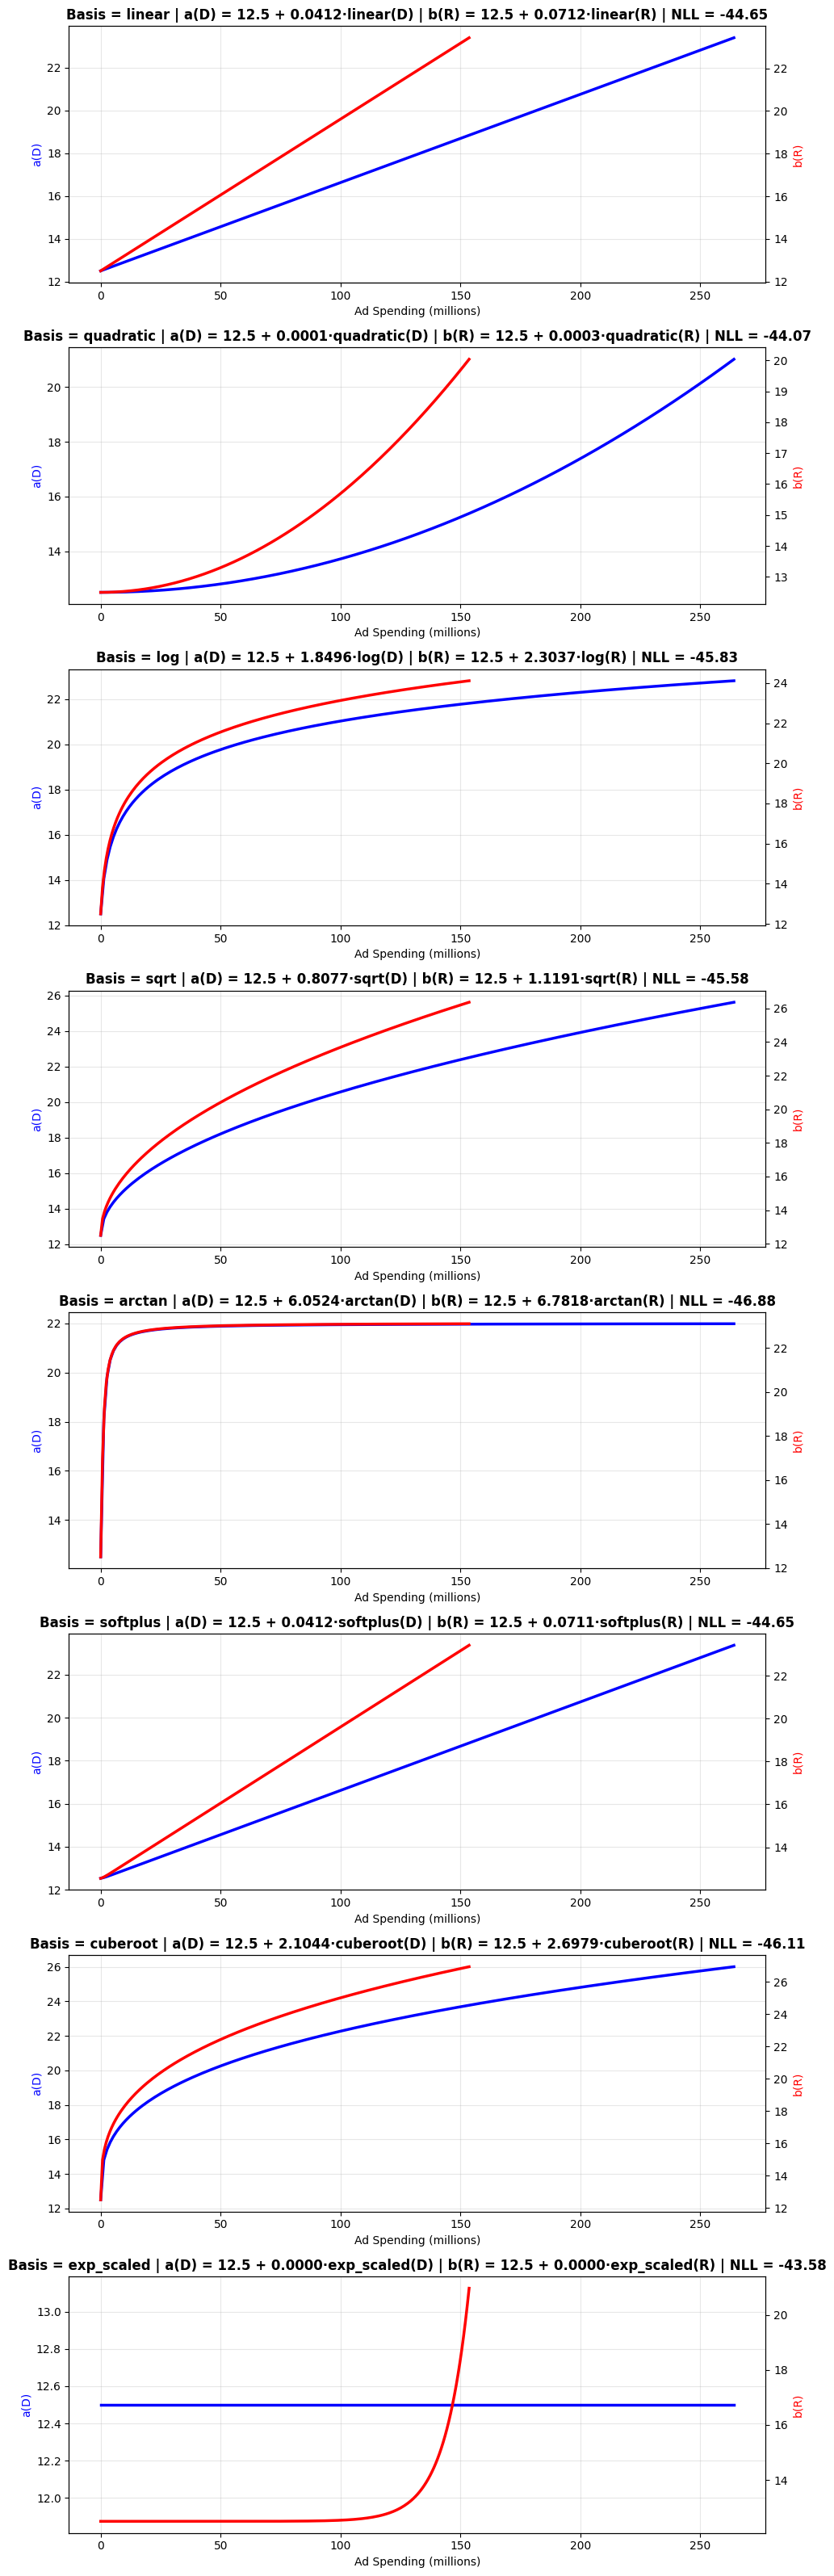

In [35]:
# This script tries multiple monotone basis families, fits beta parameters,
# and produces stacked plots (a(D) and b(R) on the same axes) exactly like
# your original visualization style.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import beta

# ------------------------------------------------------------
# Load & prepare data (assumes df_2012 ... df_2024 already exist)
# ------------------------------------------------------------
all_years_data = []
for df, year in [(df_2012, 2012), (df_2016, 2016), (df_2020, 2020), (df_2024, 2024)]:
    d = df.copy()
    d['year'] = year
    all_years_data.append(d)
combined = pd.concat(all_years_data, ignore_index=True)

D = combined['D-ad-spending'].values
R = combined['R-ad-spending'].values
yt = (combined['Turnout (D)'] - combined['Prior-Turnout (D)'])/100

mask = ~(np.isnan(D)|np.isnan(R)|np.isnan(yt))
D = D[mask]
R = R[mask]
yt = yt[mask]

# Transform to (0,1)
lo, hi = -0.2, 0.2
z = (yt - lo)/(hi-lo)
z = np.clip(z, 1e-7, 1-1e-7)

# ------------------------------------------------------------
# Diverse monotone basis functions
# (NOT only concave down)
# ------------------------------------------------------------

def f_linear(x): return x

def f_quadratic(x): return x**2  # convex

def f_log(x): return np.log(x+1)  # concave

def f_sqrt(x): return np.sqrt(x)

def f_arctan(x): return np.arctan(x)

def f_softplus(x): return np.log1p(np.exp(x))

def f_cuberoot(x): return np.cbrt(x)

def f_exp_scaled(x): return np.expm1(x/10)  # convex increasing

basis_pool = [
    f_linear,
    f_quadratic,
    f_log,
    f_sqrt,
    f_arctan,
    f_softplus,
    f_cuberoot,
    f_exp_scaled
]

basis_names = [
    'linear','quadratic','log','sqrt','arctan','softplus','cuberoot','exp_scaled'
]

# ------------------------------------------------------------
# Regression + plotting
# ------------------------------------------------------------
a0 = 12.5
b0 = 12.5

D_range = np.linspace(0, D.max()*1.2, 200)
R_range = np.linspace(0, R.max()*1.2, 200)

results = []

for f, name in zip(basis_pool, basis_names):
    def nll(params):
        a1, b1 = params
        if a1 < 0 or b1 < 0:  # monotonicity
            return 1e12
        a_vals = a0 + a1 * f(D)
        b_vals = b0 + b1 * f(R)
        if np.any(a_vals<=0) or np.any(b_vals<=0):
            return 1e12
        ll = beta.logpdf(z, a_vals, b_vals).sum()
        return -ll

    res = minimize(nll, [0.1,0.1], bounds=[(0,100),(0,100)], method='L-BFGS-B')
    a1_opt, b1_opt = res.x
    nll_val = res.fun

    results.append((f, name, a1_opt, b1_opt, nll_val))

# ------------------------------------------------------------
# EXACT plotting style: a(D) and b(R) stacked on SAME plot
# ------------------------------------------------------------

fig, axes = plt.subplots(len(results), 1, figsize=(10, 4*len(results)))
if len(results) == 1:
    axes = np.array([axes])

for ax, (f, name, a1, b1, nll_val) in zip(axes, results):
    a_curve = a0 + a1 * f(D_range)
    b_curve = b0 + b1 * f(R_range)

    ax2 = ax.twinx()

    lineA = ax.plot(D_range, a_curve, lw=2.5, label='a(D)', color='blue')
    lineB = ax2.plot(R_range, b_curve, lw=2.5, label='b(R)', color='red')

    ax.set_xlabel('Ad Spending (millions)')
    ax.set_ylabel('a(D)', color='blue')
    ax2.set_ylabel('b(R)', color='red')

    ax.set_title(
        f"Basis = {name} | a(D) = {a0:.1f} + {a1:.4f}·{name}(D) | "
        f"b(R) = {b0:.1f} + {b1:.4f}·{name}(R) | NLL = {nll_val:.2f}",
        fontweight='bold'
    )

    ax.grid(True, alpha=0.3)

fig.tight_layout()

Okay so none of those seem to be better than the log prior. The cube root working better feels more like a fluke

This is progress, but it's still ignoring a lot. The most obvious being that you don't move a set percentage of the state per dollar spent, rather you move a comparable number of people per-dollar per-state. My current models fail to take into account the size of each state. 

Honestly, I do not know what that means for my end goal of modeling alternative Electoral Collge schemes. Because if I don't do this right my models will just boil down to "you get the same number of votes no matter where you invest so go wild!"

I will explore more in the `refine.ipynb` notebook

In [36]:
# Concatenate per-year dataframes with a 'year' column and write to CSV

dfs_with_year = []
for year, df in [
    (2012, df_2012),
    (2016, df_2016),
    (2020, df_2020),
    (2024, df_2024),
]:
    temp = df.copy()
    temp['year'] = year
    dfs_with_year.append(temp)

combined_df_with_year = pd.concat(dfs_with_year, ignore_index=True)
combined_df_with_year.to_csv('ad_data.csv', index=False)